### remember to change model saving path!!!

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import random
import torch.nn as nn
from dataset import Thyroid_Dataset
from model import Eff_Unet
from HarDMSEG import HarDMSEG
from loss_metric import DiceLoss, IOU_score, StructureLoss, TverskyLoss
from LightMed.model.LightMed import LightMed
from PMFSNet.lib.models.PMFSNet import PMFSNet
from PMFSNet.lib.models.PMFSNet_FFT import PMFSNet_FFT
from hybrid_model_v3 import HybridSegModel

/home/twszbak764/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/twszbak764/.local/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/twszbak764/.local/lib/python3.12/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
import wandb
wandb.login()

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: s960068sss (s960068sss-ucl) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms.functional as tx
import random
import cv2
from PIL import ImageEnhance
from skimage.exposure import match_histograms
import torchvision.transforms as T
import torchvision.transforms.functional as F
class Ge_Benq_add_inference_Dataset(Dataset):
    def __init__(self, csv_file, transform, image_size, training = True):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.image_size = image_size
        self.training = training
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_name = self.df["image_name"][idx]
        mask_name = self.df["mask_name"][idx]
        dataset = self.df["dataset"][idx]
        mask_type = self.df["mask_type"][idx]
        from_inference = self.df["inference"][idx]
        if from_inference:
            inference_from_which_dataset = self.df["from_folder"][idx]
        
        if dataset == "ge":
            from_dataset = 1
        elif dataset == "benq":
            from_dataset = 2

        if mask_type == "nodule":
            mask_type = 1
        elif mask_type == "gland":
            mask_type = 2

        if from_inference == False:
            if dataset == "benq":
                from_folder = "../gland_data"
            elif dataset == "ge":
                if mask_type == 1:
                    from_folder = "../ge_data/nodule"
                else:
                    from_folder = "../ge_data/gland"
            
            image_path = f"{from_folder}/images/{image_name}"
            mask_path = f"{from_folder}/masks/{mask_name}"
        else:
            if inference_from_which_dataset == "ge_gland":
                image_path = f"../ge_data/gland/images/{image_name}"
                mask_path = f"../ge_data/gland/from_scratch_inference_masks_all_v1/nodule/{mask_name}"
            elif inference_from_which_dataset == "ge_video":
                image_path = f"../ge_data/from_videos/crop_images/{image_name}"
                mask_path = f"../ge_data/from_videos/inference_mask_from_scratch_v2_aug_space(0.9)_weight_decay(1e-5)/{mask_name}"
            else:
                print("not find!!")

        image = Image.open(image_path).convert("L")
        mask = Image.open(mask_path).convert("L")
        
        image_tensor, mask_tensor = self.transform(image, mask, self.image_size)
        mask_tensor = (mask_tensor > 0.5).float()
        if torch.sum(mask_tensor) == 0:
            # print("nothing")
            return [None]
        return image_tensor, mask_tensor, from_dataset, mask_type

In [5]:
image_size = 128
batch_size = 256
def train_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    p = 0.9
    
    # if(random.random() < p):
    #     jitter = T.ColorJitter(brightness = 0.5, contrast = 0.25)
    #     image = jitter(image)
    # if(random.random() < p):
    #     transform = T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
    #     image = transform(image)  # image must be a PIL image
    if(random.random() < p):
        # angle = random.uniform(-10, 10)  # 旋轉角度從 ±10 度
        angle = 0.0
        max_dx = 0.05  # 水平平移比例
        max_dy = 0.3  # 垂直平移比例
        translate_x = random.uniform(-max_dx, max_dx) * image.size[0]
        translate_y = random.uniform(-max_dy, max_dy) * image.size[1]
        translate = (int(translate_x), int(translate_y))
        scale = random.uniform(0.9, 1.6)  # 尺度縮放 ±5%
        # scale = 1.0
        # shear = [random.uniform(-5, 5), random.uniform(-5, 5)]  # 小幅剪切
        shear=[0.0, 0.0]
        image = F.affine(image, angle=angle, translate=translate, scale=scale, shear=shear)
        mask = F.affine(mask, angle=angle, translate=translate, scale=scale, shear=shear)

        
    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor
def test_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor
def custom_collate_fn(batch):
    # print(batch)
    filtered_batch = [item for item in batch if item[0] is not None]
    if len(filtered_batch) == 0:
        return [None, None, None, None]
    return torch.utils.data.dataloader.default_collate(filtered_batch)
train_dataset = Ge_Benq_add_inference_Dataset("../ge_benq_data/ge(nodule_gland)_benq(gland)_train_add_inference_v2_1.csv", transform = train_augmentation, image_size = image_size)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, collate_fn=custom_collate_fn)

test_dataset = Ge_Benq_add_inference_Dataset("../ge_benq_data/ge(nodule_gland)_benq(gland)_test_add_inference_v2_1.csv", transform = test_augmentation, image_size = image_size, training = False)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, collate_fn=custom_collate_fn)

image, mask, from_dataset, mask_type = next(iter(train_dataloader))

In [6]:
mask.shape

torch.Size([232, 1, 128, 128])

In [7]:
mask_type

tensor([1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
        1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2,
        1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 2, 1,
        2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2,
        1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2,
        2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1,
        2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1,
        2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1])

In [8]:
print(len(train_dataset), len(test_dataset))

809 229


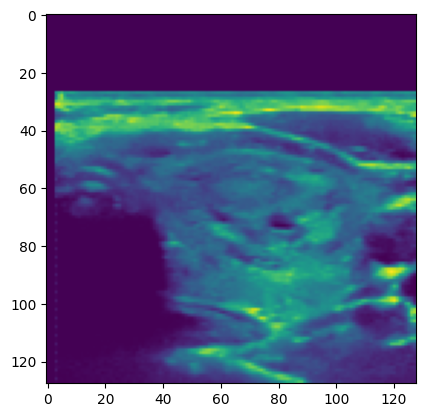

In [9]:
plt.imshow(image[18][0])

In [10]:
def train(dataloader, model, optimizer, loss_fn, device):
    total_loss = 0
    total_IOU = 0
    total_DICE = 0

    total_ge_nodule_IOU = 0
    total_ge_gland_IOU = 0
    total_benq_gland_IOU = 0
    
    total_ge_nodule_DICE = 0
    total_ge_gland_DICE = 0
    total_benq_gland_DICE = 0
    
    model.train()
    model.to(device)
    
    count = 0
    for image, mask, from_dataset, mask_type in tqdm(dataloader):
        if image == None:
            continue
        image, mask = image.to(device), mask.to(device)
        
        outputs = model(image)
        
        nodule_output = outputs[:, 0:1, :, :]
        gland_output = outputs[:, 1:2, :, :]

        # get output
        ge_nodule_output = nodule_output[(from_dataset == 1) & (mask_type == 1)]
        ge_gland_output = gland_output[(from_dataset == 1) & (mask_type == 2)]
        benq_gland_output = gland_output[(from_dataset == 2) & (mask_type == 2)]

        # get len
        ge_nodule_len = ge_nodule_output.shape[0]
        ge_gland_len = ge_gland_output.shape[0]
        benq_gland_len = benq_gland_output.shape[0]

        if ge_nodule_len == 0 or ge_gland_len == 0 or benq_gland_len == 0:
            continue

        nodule_ratio = ge_nodule_len / (ge_nodule_len + ge_gland_len + benq_gland_len)
        gland_ratio = (ge_gland_len + benq_gland_len) / (ge_nodule_len + ge_gland_len + benq_gland_len)
        
        ge_gland_ratio = ge_gland_len / (ge_gland_len + benq_gland_len)
        benq_gland_ratio = benq_gland_len / (ge_gland_len + benq_gland_len)
        
        # get mask
        ge_nodule_mask = mask[(from_dataset == 1) & (mask_type == 1)]
        ge_gland_mask = mask[(from_dataset == 1) & (mask_type == 2)]
        benq_gland_mask = mask[(from_dataset == 2) & (mask_type == 2)]
        
        #get loss
        ge_nodule_loss = loss_fn(ge_nodule_output, ge_nodule_mask)
        ge_gland_loss = loss_fn(ge_gland_output, ge_gland_mask)
        benq_gland_loss = loss_fn(benq_gland_output, benq_gland_mask)

        nodule_loss = ge_nodule_loss
        gland_loss = (ge_gland_loss * ge_gland_ratio + benq_gland_loss * benq_gland_ratio)
        loss = (nodule_loss * nodule_ratio + gland_loss * gland_ratio)
        
        # get IOU
        ge_nodule_IOU = IOU_score(ge_nodule_output, ge_nodule_mask)
        ge_gland_IOU = IOU_score(ge_gland_output, ge_gland_mask)
        benq_gland_IOU = IOU_score(benq_gland_output, benq_gland_mask)

        nodule_IOU = ge_nodule_IOU
        gland_IOU = (ge_gland_IOU * ge_gland_ratio + benq_gland_IOU * benq_gland_ratio)
        IOU = (nodule_IOU * nodule_ratio + gland_IOU * gland_ratio)

        # get DICE
        dice_loss = DiceLoss()
        
        ge_nodule_DICE = 1 - dice_loss(ge_nodule_output, ge_nodule_mask)
        ge_gland_DICE = 1 - dice_loss(ge_gland_output, ge_gland_mask)
        benq_gland_DICE = 1 - dice_loss(benq_gland_output, benq_gland_mask)

        nodule_DICE = ge_nodule_DICE
        gland_DICE = (ge_gland_DICE * ge_gland_ratio + benq_gland_DICE * benq_gland_ratio)
        DICE = (nodule_DICE * nodule_ratio + gland_DICE * gland_ratio)

        
        # Backward and optimize
        optimizer.zero_grad()   # clear previous gradients
        loss.backward()         # compute gradients
        optimizer.step()        # update weights

        total_loss += loss.item()
        total_IOU += IOU.item()
        total_DICE += DICE.item()

        total_ge_nodule_IOU += ge_nodule_IOU
        total_ge_gland_IOU += ge_gland_IOU
        total_benq_gland_IOU += benq_gland_IOU

        total_ge_nodule_DICE += ge_nodule_DICE
        total_ge_gland_DICE += ge_gland_DICE
        total_benq_gland_DICE += benq_gland_DICE
        count+=1

    return total_loss/count, total_IOU/count, total_DICE/count, total_ge_nodule_IOU/count, total_ge_gland_IOU/count, total_benq_gland_IOU/count, total_ge_nodule_DICE/count, total_ge_gland_DICE/count, total_benq_gland_DICE/count


# 
# Only calculate nodule loss, IOU, DICE, because there is no gland data in the testing set
def val(dataloader, model, loss_fn, device):
    total_loss = 0
    total_IOU = 0
    total_DICE = 0

    total_ge_nodule_IOU = 0
    total_ge_gland_IOU = 0
    total_benq_gland_IOU = 0
    
    total_ge_nodule_DICE = 0
    total_ge_gland_DICE = 0
    total_benq_gland_DICE = 0
    
    model.train()
    model.to(device)
    count = 0
    for image, mask, from_dataset, mask_type in tqdm(dataloader):
        if image == None:
            continue
        image, mask = image.to(device), mask.to(device)
        
        outputs = model(image)
        
        nodule_output = outputs[:, 0:1, :, :]
        gland_output = outputs[:, 1:2, :, :]

        # get output
        ge_nodule_output = nodule_output[(from_dataset == 1) & (mask_type == 1)]
        ge_gland_output = gland_output[(from_dataset == 1) & (mask_type == 2)]
        benq_gland_output = gland_output[(from_dataset == 2) & (mask_type == 2)]

        # get len
        ge_nodule_len = ge_nodule_output.shape[0]
        ge_gland_len = ge_gland_output.shape[0]
        benq_gland_len = benq_gland_output.shape[0]

        if ge_nodule_len == 0 or ge_gland_len == 0 or benq_gland_len == 0:
            continue
        nodule_ratio = ge_nodule_len / (ge_nodule_len + ge_gland_len + benq_gland_len)
        gland_ratio = (ge_gland_len + benq_gland_len) / (ge_nodule_len + ge_gland_len + benq_gland_len)
        
        ge_gland_ratio = ge_gland_len / (ge_gland_len + benq_gland_len)
        benq_gland_ratio = benq_gland_len / (ge_gland_len + benq_gland_len)
        
        # get mask
        ge_nodule_mask = mask[(from_dataset == 1) & (mask_type == 1)]
        ge_gland_mask = mask[(from_dataset == 1) & (mask_type == 2)]
        benq_gland_mask = mask[(from_dataset == 2) & (mask_type == 2)]
        
        #get loss
        ge_nodule_loss = loss_fn(ge_nodule_output, ge_nodule_mask)
        ge_gland_loss = loss_fn(ge_gland_output, ge_gland_mask)
        benq_gland_loss = loss_fn(benq_gland_output, benq_gland_mask)

        nodule_loss = ge_nodule_loss
        gland_loss = (ge_gland_loss * ge_gland_ratio + benq_gland_loss * benq_gland_ratio)
        loss = (nodule_loss * nodule_ratio + gland_loss * gland_ratio)
        
        # get IOU
        ge_nodule_IOU = IOU_score(ge_nodule_output, ge_nodule_mask)
        ge_gland_IOU = IOU_score(ge_gland_output, ge_gland_mask)
        benq_gland_IOU = IOU_score(benq_gland_output, benq_gland_mask)

        nodule_IOU = ge_nodule_IOU
        gland_IOU = (ge_gland_IOU * ge_gland_ratio + benq_gland_IOU * benq_gland_ratio)
        IOU = (nodule_IOU * nodule_ratio + gland_IOU * gland_ratio)

        # get DICE
        dice_loss = DiceLoss()
        
        ge_nodule_DICE = 1 - dice_loss(ge_nodule_output, ge_nodule_mask)
        ge_gland_DICE = 1 - dice_loss(ge_gland_output, ge_gland_mask)
        benq_gland_DICE = 1 - dice_loss(benq_gland_output, benq_gland_mask)

        nodule_DICE = ge_nodule_DICE
        gland_DICE = (ge_gland_DICE * ge_gland_ratio + benq_gland_DICE * benq_gland_ratio)
        DICE = (nodule_DICE * nodule_ratio + gland_DICE * gland_ratio)

        total_loss += loss.item()
        total_IOU += IOU.item()
        total_DICE += DICE.item()

        total_ge_nodule_IOU += ge_nodule_IOU
        total_ge_gland_IOU += ge_gland_IOU
        total_benq_gland_IOU += benq_gland_IOU

        total_ge_nodule_DICE += ge_nodule_DICE
        total_ge_gland_DICE += ge_gland_DICE
        total_benq_gland_DICE += benq_gland_DICE
        count+=1

    return total_loss/count, total_IOU/count, total_DICE/count, total_ge_nodule_IOU/count, total_ge_gland_IOU/count, total_benq_gland_IOU/count, total_ge_nodule_DICE/count, total_ge_gland_DICE/count, total_benq_gland_DICE/count

    

In [11]:

# inference_name = "models/Phase 1/Hybrid_crop_DDTI_standardization_aug_affine(0.5)_for_gland"
model = HybridSegModel(in_channels = 1, out_channels = 2, output_size = image_size, layers_num = 3)
# checkpoint = torch.load(f"{inference_name}/best_checkpoint.pth")
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

In [12]:
# # freeze encoder
# for param in model.backbone.parameters():
#     param.requires_grad = False

In [13]:

epochs = 500
lr = 0.01
loss_fn = StructureLoss()
# loss_fn = TverskyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay = 1e-5)
# optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [14]:

project = "thyroid_ge_benq_from_scratch"
name = "hybrid_model_ge(nodule_gland_inference)_benq(gland)_from_scratch_v3_1_aug_space(0.9)_weight_decay(1e-5)"
# name = "test"

wandb.init(
    project = project,  # Project name in W&B
    name = name,       # (optional) specific run name
    config={                     # (optional) hyperparameters
        "image_size": image_size,
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        "augmentation" : "space(0.9)",
        "weight_decay":1e-5
    }
)

In [15]:
print(f"image size : {image_size}, lr : {lr}, epochs : {epochs}, batch size : {batch_size}")

image size : 128, lr : 0.01, epochs : 500, batch size : 256


In [16]:
max_IOU = -1
max_nodule_IOU = -1
for epoch in range(epochs):
    print(f"epoch : {epoch}")
    total_loss_train, total_IOU_train, total_DICE_train, ge_nodule_IOU_train, ge_gland_IOU_train, benq_gland_IOU_train, ge_nodule_DICE_train, ge_gland_DICE_train, benq_gland_DICE_train = train(train_dataloader, model, optimizer, loss_fn, "cuda")
    print(f"train loss : {total_loss_train}, train IOU : {total_IOU_train}, train DICE : {total_DICE_train}")
    total_loss_val, total_IOU_val, total_DICE_val, ge_nodule_IOU_val, ge_gland_IOU_val, benq_gland_IOU_val, ge_nodule_DICE_val, ge_gland_DICE_val, benq_gland_DICE_val = val(test_dataloader, model, loss_fn, "cuda")
    print(f"val loss : {total_loss_val}, val IOU : {total_IOU_val}, val DICE : {total_DICE_val}")
    
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]



    if max_IOU < total_IOU_val:
        max_IOU = total_IOU_val
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            "IOU" : total_IOU_val,
            "DICE" : total_DICE_val,
            "loss" : total_loss_val
        }
        folder = f"models/from_scratch/ge_benq_inference/{name}/"
        os.makedirs(folder, exist_ok = True)
        torch.save(checkpoint, f"{folder}/best_checkpoint.pth")

    if max_nodule_IOU < ge_nodule_IOU_val:
        max_nodule_IOU = ge_nodule_IOU_val
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            "IOU" : total_IOU_val,
            "DICE" : total_DICE_val,
            "loss" : total_loss_val
        }
        folder = f"models/from_scratch/ge_benq_inference/{name}/"
        os.makedirs(folder, exist_ok = True)
        torch.save(checkpoint, f"{folder}/nodule_best_checkpoint.pth")
        
    wandb.log({
        "epoch": epoch,
        "Learning Rate":current_lr,
        
        "train_loss": total_loss_train,
        "train_IOU": total_IOU_train,
        "train_DICE": total_DICE_train,
        "train_ge_nodule_IOU" : ge_nodule_IOU_train,
        "train_ge_nodule_DICE" : ge_nodule_DICE_train,
        "train_ge_gland_IOU" : ge_gland_IOU_train,
        "train_ge_gland_DICE" : ge_gland_DICE_train,
        "train_benq_gland_IOU" : benq_gland_IOU_train,
        "train_benq_gland_DICE" : benq_gland_DICE_train,
        
        "val_loss": total_loss_val,
        "val_IOU": total_IOU_val,
        "val_DICE": total_DICE_val,
        "val_ge_nodule_IOU" : ge_nodule_IOU_val,
        "val_ge_nodule_DICE" : ge_nodule_DICE_val,
        "val_ge_gland_IOU" : ge_gland_IOU_val,
        "val_ge_gland_DICE" : ge_gland_DICE_val,
        "val_benq_gland_IOU" : benq_gland_IOU_val,
        "val_benq_gland_DICE" : benq_gland_DICE_val,
        
    })




checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    "IOU" : total_IOU_val,
    "DICE" : total_DICE_val,
    "loss" : total_loss_val
}
torch.save(checkpoint, f"{folder}/last_checkpoint.pth")
wandb.finish()

epoch : 0


/home/twszbak764/miniconda3/envs/thyroid/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 4/4 [00:11<00:00,  2.81s/it]


train loss : 1.2826111018657684, train IOU : 0.08645311649888754, train DICE : 0.19821473583579063


100%|██████████| 1/1 [00:02<00:00,  2.87s/it]


val loss : 1.1453721523284912, val IOU : 0.09381823241710663, val DICE : 0.22820279002189636
epoch : 1


100%|██████████| 4/4 [00:10<00:00,  2.65s/it]


train loss : 1.3017377257347107, train IOU : 0.06181825930252671, train DICE : 0.21616419591009617


100%|██████████| 1/1 [00:02<00:00,  2.85s/it]


val loss : 1.1662414073944092, val IOU : 0.10535527765750885, val DICE : 0.2104986160993576
epoch : 2


100%|██████████| 4/4 [00:10<00:00,  2.67s/it]


train loss : 1.0410884618759155, train IOU : 0.09783109650015831, train DICE : 0.26407546922564507


100%|██████████| 1/1 [00:02<00:00,  2.83s/it]


val loss : 1.0963160991668701, val IOU : 0.171864315867424, val DICE : 0.2844638228416443
epoch : 3


100%|██████████| 4/4 [00:10<00:00,  2.66s/it]


train loss : 0.9946294873952866, train IOU : 0.13384993001818657, train DICE : 0.32072870433330536


100%|██████████| 1/1 [00:02<00:00,  2.86s/it]


val loss : 1.0708335638046265, val IOU : 0.22773508727550507, val DICE : 0.3098922669887543
epoch : 4


100%|██████████| 4/4 [00:10<00:00,  2.70s/it]


train loss : 0.9395181089639664, train IOU : 0.27179284021258354, train DICE : 0.38602472841739655


100%|██████████| 1/1 [00:02<00:00,  2.89s/it]


val loss : 1.0140379667282104, val IOU : 0.2716197371482849, val DICE : 0.36327576637268066
epoch : 5


100%|██████████| 4/4 [00:10<00:00,  2.66s/it]


train loss : 0.8907792717218399, train IOU : 0.3307086080312729, train DICE : 0.42944201081991196


100%|██████████| 1/1 [00:02<00:00,  2.84s/it]


val loss : 0.9851551055908203, val IOU : 0.2861141860485077, val DICE : 0.38227611780166626
epoch : 6


100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


train loss : 0.8499851524829865, train IOU : 0.34819672256708145, train DICE : 0.4635721370577812


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


val loss : 0.900924801826477, val IOU : 0.3652026951313019, val DICE : 0.46727097034454346
epoch : 7


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.8192341327667236, train IOU : 0.38085957368214923, train DICE : 0.5040553708871206


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.8759835362434387, val IOU : 0.3814800977706909, val DICE : 0.4737616777420044
epoch : 8


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.7995930165052414, train IOU : 0.3838295340538025, train DICE : 0.5131263136863708


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


val loss : 0.8761807680130005, val IOU : 0.3807845115661621, val DICE : 0.48509907722473145
epoch : 9


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.7421944588422775, train IOU : 0.43093062937259674, train DICE : 0.5462849289178848


100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


val loss : 0.8774750232696533, val IOU : 0.3835957944393158, val DICE : 0.4775427281856537
epoch : 10


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.7763010412454605, train IOU : 0.3977554887533188, train DICE : 0.5227943509817123


100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


val loss : 0.836349368095398, val IOU : 0.41770023107528687, val DICE : 0.5330065488815308
epoch : 11


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.7290875017642975, train IOU : 0.43039657920598984, train DICE : 0.5704268217086792


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.7768568396568298, val IOU : 0.4557749629020691, val DICE : 0.5750106573104858
epoch : 12


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.7000342458486557, train IOU : 0.44960083067417145, train DICE : 0.5887021571397781


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.8280197381973267, val IOU : 0.4097018539905548, val DICE : 0.5259255766868591
epoch : 13


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.6908952295780182, train IOU : 0.4678104892373085, train DICE : 0.5946952700614929


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.8193414807319641, val IOU : 0.4236584007740021, val DICE : 0.546161413192749
epoch : 14


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.6745220422744751, train IOU : 0.4788658544421196, train DICE : 0.6168936789035797


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.8500813245773315, val IOU : 0.4046120047569275, val DICE : 0.5259185433387756
epoch : 15


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.6610892216364542, train IOU : 0.48144227266311646, train DICE : 0.6098882357279459


100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


val loss : 0.766351580619812, val IOU : 0.45317381620407104, val DICE : 0.581161618232727
epoch : 16


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.6145925968885422, train IOU : 0.5160583853721619, train DICE : 0.6411641091108322


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


val loss : 0.7211917638778687, val IOU : 0.5008313655853271, val DICE : 0.6236810684204102
epoch : 17


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.6508330851793289, train IOU : 0.5014459937810898, train DICE : 0.6370017677545547


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


val loss : 0.710189938545227, val IOU : 0.4861232042312622, val DICE : 0.6178039312362671
epoch : 18


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.6249656478563944, train IOU : 0.5100402037302653, train DICE : 0.6404355963071188


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.796425461769104, val IOU : 0.45198482275009155, val DICE : 0.5717777609825134
epoch : 19


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.616142138838768, train IOU : 0.5223587453365326, train DICE : 0.6465992331504822


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.8307040929794312, val IOU : 0.41690361499786377, val DICE : 0.5333390831947327
epoch : 20


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.6019763797521591, train IOU : 0.5129462629556656, train DICE : 0.642785370349884


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.8095746040344238, val IOU : 0.4589456617832184, val DICE : 0.5745015144348145
epoch : 21


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.6318408697843552, train IOU : 0.5043693780899048, train DICE : 0.6371825784444809


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.7483639717102051, val IOU : 0.48160260915756226, val DICE : 0.5907300710678101
epoch : 22


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.5909491628408432, train IOU : 0.5396896153688431, train DICE : 0.6584727168083191


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.7020976543426514, val IOU : 0.5040384531021118, val DICE : 0.6284019351005554
epoch : 23


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.580208495259285, train IOU : 0.5597220659255981, train DICE : 0.6740632951259613


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


val loss : 0.7631890773773193, val IOU : 0.4781598150730133, val DICE : 0.6034514904022217
epoch : 24


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.5701775401830673, train IOU : 0.5570744276046753, train DICE : 0.694039061665535


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


val loss : 0.7707995772361755, val IOU : 0.48542463779449463, val DICE : 0.6081801056861877
epoch : 25


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.5458734780550003, train IOU : 0.5744118690490723, train DICE : 0.6972265988588333


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


val loss : 0.7470054626464844, val IOU : 0.49526292085647583, val DICE : 0.6175073385238647
epoch : 26


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.5407269150018692, train IOU : 0.5839187055826187, train DICE : 0.7053535878658295


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.7081317901611328, val IOU : 0.5201249122619629, val DICE : 0.6371181011199951
epoch : 27


100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


train loss : 0.5370453149080276, train IOU : 0.5804915279150009, train DICE : 0.7047369331121445


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.7114928960800171, val IOU : 0.5165452361106873, val DICE : 0.6365593671798706
epoch : 28


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.5118434578180313, train IOU : 0.6111976504325867, train DICE : 0.721828505396843


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.7292371392250061, val IOU : 0.49909842014312744, val DICE : 0.6264798641204834
epoch : 29


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.48741907626390457, train IOU : 0.6204671859741211, train DICE : 0.7406080216169357


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.6993848085403442, val IOU : 0.5301895141601562, val DICE : 0.6516543626785278
epoch : 30


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.4939619451761246, train IOU : 0.6173917353153229, train DICE : 0.7418599128723145


100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


val loss : 0.7464640736579895, val IOU : 0.5124917030334473, val DICE : 0.6174615621566772
epoch : 31


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.49948785454034805, train IOU : 0.6132796853780746, train DICE : 0.7433920055627823


100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


val loss : 0.6506815552711487, val IOU : 0.5529434680938721, val DICE : 0.680732250213623
epoch : 32


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.5241483151912689, train IOU : 0.5860059708356857, train DICE : 0.7070549428462982


100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


val loss : 0.7107541561126709, val IOU : 0.5238112807273865, val DICE : 0.6340325474739075
epoch : 33


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.4757428243756294, train IOU : 0.6239125579595566, train DICE : 0.7367947101593018


100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


val loss : 0.7133194804191589, val IOU : 0.5265629887580872, val DICE : 0.6393862962722778
epoch : 34


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.47481607645750046, train IOU : 0.6355162262916565, train DICE : 0.7563245594501495


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.6778838038444519, val IOU : 0.5343629121780396, val DICE : 0.6606314182281494
epoch : 35


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.470237173140049, train IOU : 0.6292189210653305, train DICE : 0.7546922117471695


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


val loss : 0.7434045672416687, val IOU : 0.5133012533187866, val DICE : 0.6278311610221863
epoch : 36


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.4561642184853554, train IOU : 0.6477992087602615, train DICE : 0.7660082131624222


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.7537016868591309, val IOU : 0.49823442101478577, val DICE : 0.6350142955780029
epoch : 37


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.4623447582125664, train IOU : 0.6379378885030746, train DICE : 0.7625091820955276


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


val loss : 0.707775354385376, val IOU : 0.5309699177742004, val DICE : 0.640311598777771
epoch : 38


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.4667143076658249, train IOU : 0.6318976879119873, train DICE : 0.7601033598184586


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.6455826759338379, val IOU : 0.562526285648346, val DICE : 0.6911945939064026
epoch : 39


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.4243398830294609, train IOU : 0.6719373166561127, train DICE : 0.7884458750486374


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


val loss : 0.6323955655097961, val IOU : 0.5786328315734863, val DICE : 0.6915500164031982
epoch : 40


100%|██████████| 4/4 [00:10<00:00,  2.69s/it]


train loss : 0.4365702345967293, train IOU : 0.6640333980321884, train DICE : 0.7825963795185089


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


val loss : 0.6900854110717773, val IOU : 0.5320977568626404, val DICE : 0.6549906730651855
epoch : 41


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.4331815044085185, train IOU : 0.6623436609903971, train DICE : 0.783641497294108


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.6716639995574951, val IOU : 0.5638676881790161, val DICE : 0.6813393831253052
epoch : 42


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.42361391335725784, train IOU : 0.678223505616188, train DICE : 0.7917123883962631


100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


val loss : 0.7006188631057739, val IOU : 0.5414865016937256, val DICE : 0.6623947024345398
epoch : 43


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.4056750759482384, train IOU : 0.6931908428668976, train DICE : 0.8012302815914154


100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


val loss : 0.6336228847503662, val IOU : 0.5871132016181946, val DICE : 0.6949108839035034
epoch : 44


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.39690857380628586, train IOU : 0.684365302324295, train DICE : 0.7991505712270737


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.6342170238494873, val IOU : 0.5870686769485474, val DICE : 0.7043427228927612
epoch : 45


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.40132956951856613, train IOU : 0.6898146271705627, train DICE : 0.8042630851268768


100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


val loss : 0.6379355192184448, val IOU : 0.5689454078674316, val DICE : 0.6952126026153564
epoch : 46


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.3962494432926178, train IOU : 0.675795391201973, train DICE : 0.7935882657766342


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.643368124961853, val IOU : 0.5743255019187927, val DICE : 0.700661838054657
epoch : 47


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.41475775092840195, train IOU : 0.673381045460701, train DICE : 0.795646458864212


100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


val loss : 0.6246010661125183, val IOU : 0.5811768770217896, val DICE : 0.6993857622146606
epoch : 48


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.38137590140104294, train IOU : 0.6994007378816605, train DICE : 0.8138144463300705


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


val loss : 0.6017194986343384, val IOU : 0.6005313396453857, val DICE : 0.7198936939239502
epoch : 49


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.37385036051273346, train IOU : 0.708221048116684, train DICE : 0.8261352330446243


100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


val loss : 0.6233037114143372, val IOU : 0.5880299806594849, val DICE : 0.7137399911880493
epoch : 50


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.369746632874012, train IOU : 0.7171751111745834, train DICE : 0.8261030912399292


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


val loss : 0.5583707094192505, val IOU : 0.623099684715271, val DICE : 0.7397858500480652
epoch : 51


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.35899338126182556, train IOU : 0.7258340865373611, train DICE : 0.8322603702545166


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


val loss : 0.5796703696250916, val IOU : 0.6165984869003296, val DICE : 0.7287584543228149
epoch : 52


100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


train loss : 0.34437933564186096, train IOU : 0.7334577143192291, train DICE : 0.8396286368370056


100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


val loss : 0.5806633830070496, val IOU : 0.6232812404632568, val DICE : 0.7389746904373169
epoch : 53


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.33640607446432114, train IOU : 0.7416329979896545, train DICE : 0.841998815536499


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


val loss : 0.5723719596862793, val IOU : 0.6189520359039307, val DICE : 0.7392260432243347
epoch : 54


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.3406766802072525, train IOU : 0.7392704337835312, train DICE : 0.8445961624383926


100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


val loss : 0.5874892473220825, val IOU : 0.6103547811508179, val DICE : 0.7326241731643677
epoch : 55


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.350713275372982, train IOU : 0.7316905707120895, train DICE : 0.8411459475755692


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


val loss : 0.7059153318405151, val IOU : 0.5607430934906006, val DICE : 0.6918168067932129
epoch : 56


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.343348428606987, train IOU : 0.7320699840784073, train DICE : 0.8390996754169464


100%|██████████| 1/1 [00:02<00:00,  2.86s/it]


val loss : 0.5847468972206116, val IOU : 0.612736165523529, val DICE : 0.7306348085403442
epoch : 57


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.3423266261816025, train IOU : 0.7377889454364777, train DICE : 0.8507171422243118


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


val loss : 0.581678032875061, val IOU : 0.6185508370399475, val DICE : 0.7359497547149658
epoch : 58


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.339120551943779, train IOU : 0.7335985153913498, train DICE : 0.8383079469203949


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.5570164918899536, val IOU : 0.6302604675292969, val DICE : 0.7514897584915161
epoch : 59


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.33025842905044556, train IOU : 0.7393042594194412, train DICE : 0.8437944650650024


100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


val loss : 0.5993771553039551, val IOU : 0.6048539280891418, val DICE : 0.7323836088180542
epoch : 60


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.328776756922404, train IOU : 0.7422771453857422, train DICE : 0.8513201475143433


100%|██████████| 1/1 [00:02<00:00,  2.84s/it]


val loss : 0.5825068354606628, val IOU : 0.6122635006904602, val DICE : 0.7374975681304932
epoch : 61


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.3177204057574272, train IOU : 0.7558519095182419, train DICE : 0.8583122342824936


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


val loss : 0.5473003387451172, val IOU : 0.6346596479415894, val DICE : 0.7556818723678589
epoch : 62


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.3167989104986191, train IOU : 0.7425593286752701, train DICE : 0.8509698659181595


100%|██████████| 1/1 [00:02<00:00,  2.84s/it]


val loss : 0.5610074996948242, val IOU : 0.6307047605514526, val DICE : 0.7520981431007385
epoch : 63


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.29826701432466507, train IOU : 0.7737168669700623, train DICE : 0.8702293932437897


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


val loss : 0.5427917838096619, val IOU : 0.6489946246147156, val DICE : 0.7676789164543152
epoch : 64


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.287553034722805, train IOU : 0.77342090010643, train DICE : 0.8712368011474609


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


val loss : 0.5583972334861755, val IOU : 0.6290475130081177, val DICE : 0.7500278353691101
epoch : 65


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.28703606873750687, train IOU : 0.7805485427379608, train DICE : 0.8733023256063461


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


val loss : 0.5537527799606323, val IOU : 0.6310919523239136, val DICE : 0.7557204961776733
epoch : 66


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.2861309051513672, train IOU : 0.7785800248384476, train DICE : 0.8734947144985199


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.6340106725692749, val IOU : 0.5847511291503906, val DICE : 0.7267411947250366
epoch : 67


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.3557412847876549, train IOU : 0.7111753225326538, train DICE : 0.8369074910879135


100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


val loss : 0.5079869031906128, val IOU : 0.6599101424217224, val DICE : 0.7787272930145264
epoch : 68


100%|██████████| 4/4 [00:10<00:00,  2.65s/it]


train loss : 0.310651995241642, train IOU : 0.7586777061223984, train DICE : 0.8617539554834366


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.5352371335029602, val IOU : 0.6426814198493958, val DICE : 0.7648249864578247
epoch : 69


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.3206971511244774, train IOU : 0.744201585650444, train DICE : 0.85996313393116


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.5767829418182373, val IOU : 0.6368016004562378, val DICE : 0.7569657564163208
epoch : 70


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.2969107925891876, train IOU : 0.7604517489671707, train DICE : 0.8586139678955078


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.589812159538269, val IOU : 0.6296067833900452, val DICE : 0.7465256452560425
epoch : 71


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.2924744561314583, train IOU : 0.7737830579280853, train DICE : 0.8741374462842941


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


val loss : 0.5976341366767883, val IOU : 0.6241395473480225, val DICE : 0.7500658631324768
epoch : 72


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.29177312552928925, train IOU : 0.7673354744911194, train DICE : 0.8721482157707214


100%|██████████| 1/1 [00:02<00:00,  2.83s/it]


val loss : 0.5374610424041748, val IOU : 0.6411345601081848, val DICE : 0.7678805589675903
epoch : 73


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.2851872220635414, train IOU : 0.7791329622268677, train DICE : 0.8762934803962708


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.5256035923957825, val IOU : 0.6552163362503052, val DICE : 0.7770872712135315
epoch : 74


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.2750306650996208, train IOU : 0.7793141305446625, train DICE : 0.87663933634758


100%|██████████| 1/1 [00:02<00:00,  2.83s/it]


val loss : 0.5604352951049805, val IOU : 0.6427944898605347, val DICE : 0.7614376544952393
epoch : 75


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.285223051905632, train IOU : 0.7818028479814529, train DICE : 0.8744276762008667


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.5764840841293335, val IOU : 0.6323921084403992, val DICE : 0.752962589263916
epoch : 76


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.27180858701467514, train IOU : 0.7904339730739594, train DICE : 0.8868630975484848


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


val loss : 0.5274920463562012, val IOU : 0.6530073881149292, val DICE : 0.774361252784729
epoch : 77


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.26540523022413254, train IOU : 0.7894981950521469, train DICE : 0.880265086889267


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


val loss : 0.5145201683044434, val IOU : 0.6565016508102417, val DICE : 0.7806923985481262
epoch : 78


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.2609468325972557, train IOU : 0.7915962934494019, train DICE : 0.8873376995325089


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


val loss : 0.6211107969284058, val IOU : 0.6107150316238403, val DICE : 0.7433689832687378
epoch : 79


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.272620752453804, train IOU : 0.7843346893787384, train DICE : 0.8789335638284683


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.5061690807342529, val IOU : 0.6712738275527954, val DICE : 0.7895589470863342
epoch : 80


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.27171802520751953, train IOU : 0.7749640047550201, train DICE : 0.8778136521577835


100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


val loss : 0.5165196657180786, val IOU : 0.6623440980911255, val DICE : 0.7789092063903809
epoch : 81


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.26202914863824844, train IOU : 0.7980682700872421, train DICE : 0.8878986090421677


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


val loss : 0.5110130906105042, val IOU : 0.66294264793396, val DICE : 0.7766932249069214
epoch : 82


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.2432372123003006, train IOU : 0.7952542454004288, train DICE : 0.8929296433925629


100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


val loss : 0.4951353073120117, val IOU : 0.6798297166824341, val DICE : 0.793045163154602
epoch : 83


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.26559967175126076, train IOU : 0.7896016538143158, train DICE : 0.8861742317676544


100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


val loss : 0.53196120262146, val IOU : 0.657464861869812, val DICE : 0.7806483507156372
epoch : 84


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.2560027800500393, train IOU : 0.8091263025999069, train DICE : 0.8984611928462982


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.5449062585830688, val IOU : 0.6517143845558167, val DICE : 0.7723381519317627
epoch : 85


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.2581375055015087, train IOU : 0.7914913892745972, train DICE : 0.8868656903505325


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.5482449531555176, val IOU : 0.6483181715011597, val DICE : 0.7700486183166504
epoch : 86


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.25047991424798965, train IOU : 0.802277222275734, train DICE : 0.8944082111120224


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.5758501291275024, val IOU : 0.641840398311615, val DICE : 0.7666263580322266
epoch : 87


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.2630588263273239, train IOU : 0.8047875016927719, train DICE : 0.8955105096101761


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


val loss : 0.5328373908996582, val IOU : 0.6594536304473877, val DICE : 0.7777669429779053
epoch : 88


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.25529566407203674, train IOU : 0.7903579920530319, train DICE : 0.8950760811567307


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.5185146927833557, val IOU : 0.6680409908294678, val DICE : 0.7853083610534668
epoch : 89


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.24158760408560434, train IOU : 0.8092228372891744, train DICE : 0.8987035751342773


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


val loss : 0.5245697498321533, val IOU : 0.668350875377655, val DICE : 0.7825224995613098
epoch : 90


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.2500753179192543, train IOU : 0.7985365688800812, train DICE : 0.8917692303657532


100%|██████████| 1/1 [00:02<00:00,  2.84s/it]


val loss : 0.514228880405426, val IOU : 0.6660856008529663, val DICE : 0.7868730425834656
epoch : 91


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.23717928677797318, train IOU : 0.8144184798002243, train DICE : 0.9035851210355759


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.5377706289291382, val IOU : 0.6592763066291809, val DICE : 0.7785351276397705
epoch : 92


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.23968521133065224, train IOU : 0.811375692486763, train DICE : 0.9004726856946945


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.49884313344955444, val IOU : 0.6801651120185852, val DICE : 0.7949148416519165
epoch : 93


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.23558495566248894, train IOU : 0.8031691908836365, train DICE : 0.8984806537628174


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.49651914834976196, val IOU : 0.6773086786270142, val DICE : 0.792387068271637
epoch : 94


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.24399945884943008, train IOU : 0.8144367039203644, train DICE : 0.9003439843654633


100%|██████████| 1/1 [00:02<00:00,  2.83s/it]


val loss : 0.5339492559432983, val IOU : 0.6576115489006042, val DICE : 0.7794039249420166
epoch : 95


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.2421434223651886, train IOU : 0.8087247461080551, train DICE : 0.8930726647377014


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.535742998123169, val IOU : 0.670354425907135, val DICE : 0.7838770151138306
epoch : 96


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.24440107494592667, train IOU : 0.8031651675701141, train DICE : 0.8969098627567291


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.4957888126373291, val IOU : 0.6833149194717407, val DICE : 0.7974991798400879
epoch : 97


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.24381037428975105, train IOU : 0.8116791397333145, train DICE : 0.9003855884075165


100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


val loss : 0.5382004976272583, val IOU : 0.6546231508255005, val DICE : 0.7838966846466064
epoch : 98


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.23069916665554047, train IOU : 0.809845358133316, train DICE : 0.9017013907432556


100%|██████████| 1/1 [00:02<00:00,  2.83s/it]


val loss : 0.5460726618766785, val IOU : 0.6676393747329712, val DICE : 0.7883870005607605
epoch : 99


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.23265139758586884, train IOU : 0.8165703415870667, train DICE : 0.9060046225786209


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


val loss : 0.5400351881980896, val IOU : 0.6647820472717285, val DICE : 0.7862592935562134
epoch : 100


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.2222827486693859, train IOU : 0.8224921971559525, train DICE : 0.9080908596515656


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.5372098684310913, val IOU : 0.6683260202407837, val DICE : 0.7834393978118896
epoch : 101


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.227337546646595, train IOU : 0.8245855271816254, train DICE : 0.9091820269823074


100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


val loss : 0.5042365193367004, val IOU : 0.6742732524871826, val DICE : 0.7879195809364319
epoch : 102


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.2511025294661522, train IOU : 0.7989961504936218, train DICE : 0.8959079682826996


100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


val loss : 0.49149876832962036, val IOU : 0.685020923614502, val DICE : 0.798321008682251
epoch : 103


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.2385898418724537, train IOU : 0.8124169260263443, train DICE : 0.8994588106870651


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


val loss : 0.5567024350166321, val IOU : 0.6586265563964844, val DICE : 0.7764216661453247
epoch : 104


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.2543211467564106, train IOU : 0.811880424618721, train DICE : 0.8937576711177826


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


val loss : 0.5319985747337341, val IOU : 0.6616359949111938, val DICE : 0.7794615030288696
epoch : 105


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.24562890455126762, train IOU : 0.8008958846330643, train DICE : 0.893468901515007


100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


val loss : 0.4894522428512573, val IOU : 0.6836671233177185, val DICE : 0.7992470860481262
epoch : 106


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.23304016515612602, train IOU : 0.8138242363929749, train DICE : 0.8996385037899017


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


val loss : 0.48411887884140015, val IOU : 0.680463433265686, val DICE : 0.798679769039154
epoch : 107


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.23841076716780663, train IOU : 0.8133509159088135, train DICE : 0.8998637348413467


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.5618034601211548, val IOU : 0.6605609059333801, val DICE : 0.7730852365493774
epoch : 108


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.23165642097592354, train IOU : 0.8274767994880676, train DICE : 0.9068069010972977


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


val loss : 0.5595179200172424, val IOU : 0.6490585207939148, val DICE : 0.7636202573776245
epoch : 109


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.23063142597675323, train IOU : 0.8105000704526901, train DICE : 0.8989732414484024


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.5596668720245361, val IOU : 0.6519213914871216, val DICE : 0.7704485654830933
epoch : 110


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.22098887339234352, train IOU : 0.8286690413951874, train DICE : 0.91058050096035


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.5237239003181458, val IOU : 0.6603701710700989, val DICE : 0.7857782244682312
epoch : 111


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.23447497934103012, train IOU : 0.8165181577205658, train DICE : 0.9061716049909592


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


val loss : 0.5094001889228821, val IOU : 0.6720510721206665, val DICE : 0.7924895286560059
epoch : 112


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.21843267604708672, train IOU : 0.8238159865140915, train DICE : 0.9095450937747955


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


val loss : 0.4879947304725647, val IOU : 0.6874077320098877, val DICE : 0.8020436763763428
epoch : 113


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.22969911992549896, train IOU : 0.8225678652524948, train DICE : 0.9107457995414734


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


val loss : 0.49071335792541504, val IOU : 0.6767014265060425, val DICE : 0.7919458746910095
epoch : 114


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.22155814617872238, train IOU : 0.8130771815776825, train DICE : 0.9055919945240021


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.4677707552909851, val IOU : 0.699597954750061, val DICE : 0.8080273270606995
epoch : 115


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.22228283435106277, train IOU : 0.8272873908281326, train DICE : 0.9140589684247971


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.5162355303764343, val IOU : 0.665902853012085, val DICE : 0.7888448238372803
epoch : 116


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.21578192710876465, train IOU : 0.8215609788894653, train DICE : 0.9144850671291351


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.4722469747066498, val IOU : 0.6942297220230103, val DICE : 0.8082969188690186
epoch : 117


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.21211901307106018, train IOU : 0.8280719518661499, train DICE : 0.9110336452722549


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.5007690787315369, val IOU : 0.6732759475708008, val DICE : 0.7961589097976685
epoch : 118


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.21476241573691368, train IOU : 0.8289968073368073, train DICE : 0.91542187333107


100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


val loss : 0.4890511631965637, val IOU : 0.6913263201713562, val DICE : 0.8047127723693848
epoch : 119


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.21307799220085144, train IOU : 0.8268861770629883, train DICE : 0.913393035531044


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


val loss : 0.5052791833877563, val IOU : 0.6730892658233643, val DICE : 0.7884986400604248
epoch : 120


100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


train loss : 0.20909464359283447, train IOU : 0.8300347775220871, train DICE : 0.9129670858383179


100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


val loss : 0.4942976236343384, val IOU : 0.6912535429000854, val DICE : 0.799618124961853
epoch : 121


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.20501727238297462, train IOU : 0.8420994728803635, train DICE : 0.9178363680839539


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


val loss : 0.4849150776863098, val IOU : 0.6961629390716553, val DICE : 0.8071862459182739
epoch : 122


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.21692955121397972, train IOU : 0.8358220756053925, train DICE : 0.9159822165966034


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.43977028131484985, val IOU : 0.7159476280212402, val DICE : 0.8200933933258057
epoch : 123


100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


train loss : 0.21497131884098053, train IOU : 0.828850269317627, train DICE : 0.9150573313236237


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


val loss : 0.4401726722717285, val IOU : 0.7097210884094238, val DICE : 0.8136630654335022
epoch : 124


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.20989378169178963, train IOU : 0.8380312323570251, train DICE : 0.9162743538618088


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.45966312289237976, val IOU : 0.6979849338531494, val DICE : 0.8019010424613953
epoch : 125


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.20565970614552498, train IOU : 0.8264036774635315, train DICE : 0.9155130237340927


100%|██████████| 1/1 [00:02<00:00,  2.86s/it]


val loss : 0.46351349353790283, val IOU : 0.705429196357727, val DICE : 0.8127541542053223
epoch : 126


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.20796682313084602, train IOU : 0.8379251211881638, train DICE : 0.9174693375825882


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.4809021055698395, val IOU : 0.6865094900131226, val DICE : 0.799132227897644
epoch : 127


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.20637108758091927, train IOU : 0.8340829014778137, train DICE : 0.9164723753929138


100%|██████████| 1/1 [00:02<00:00,  2.83s/it]


val loss : 0.4620019197463989, val IOU : 0.7024621963500977, val DICE : 0.8076665997505188
epoch : 128


100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


train loss : 0.20938539132475853, train IOU : 0.8309728056192398, train DICE : 0.9156487584114075


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.48760324716567993, val IOU : 0.6934705972671509, val DICE : 0.8031670451164246
epoch : 129


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.1949865147471428, train IOU : 0.8432290703058243, train DICE : 0.9197070151567459


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.4965035021305084, val IOU : 0.6897517442703247, val DICE : 0.7981150150299072
epoch : 130


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.19959865137934685, train IOU : 0.8322992920875549, train DICE : 0.9179215729236603


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


val loss : 0.4440743327140808, val IOU : 0.7214680910110474, val DICE : 0.8232486248016357
epoch : 131


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.2058173194527626, train IOU : 0.8406400233507156, train DICE : 0.9197408258914948


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


val loss : 0.4888532757759094, val IOU : 0.6884679198265076, val DICE : 0.8011746406555176
epoch : 132


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.20938459038734436, train IOU : 0.8139966875314713, train DICE : 0.9121934473514557


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


val loss : 0.5100687742233276, val IOU : 0.6922804117202759, val DICE : 0.7988380193710327
epoch : 133


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.2063213735818863, train IOU : 0.8419218212366104, train DICE : 0.9196134209632874


100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


val loss : 0.4799386262893677, val IOU : 0.7011201977729797, val DICE : 0.8076380491256714
epoch : 134


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.21307378510634103, train IOU : 0.8241533637046814, train DICE : 0.9107826352119446


100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


val loss : 0.469812273979187, val IOU : 0.7010028958320618, val DICE : 0.8074791431427002
epoch : 135


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.2001548558473587, train IOU : 0.8404023349285126, train DICE : 0.9188470542430878


100%|██████████| 1/1 [00:02<00:00,  2.85s/it]


val loss : 0.44882047176361084, val IOU : 0.7156360149383545, val DICE : 0.8218597769737244
epoch : 136


100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


train loss : 0.19533808529376984, train IOU : 0.8422481864690781, train DICE : 0.9216530621051788


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.4622294306755066, val IOU : 0.7101857662200928, val DICE : 0.8171302080154419
epoch : 137


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.19790910929441452, train IOU : 0.8442374616861343, train DICE : 0.9191019088029861


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


val loss : 0.5202324986457825, val IOU : 0.6855797171592712, val DICE : 0.7961412668228149
epoch : 138


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.2043624222278595, train IOU : 0.8373647481203079, train DICE : 0.9154980331659317


100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


val loss : 0.5013909339904785, val IOU : 0.6912903785705566, val DICE : 0.7999098300933838
epoch : 139


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.20406564325094223, train IOU : 0.8409200757741928, train DICE : 0.918435588479042


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.45455265045166016, val IOU : 0.7070119380950928, val DICE : 0.8101767301559448
epoch : 140


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.2046574354171753, train IOU : 0.8332557082176208, train DICE : 0.9161044955253601


100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


val loss : 0.4637005925178528, val IOU : 0.7001156806945801, val DICE : 0.8057695627212524
epoch : 141


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.19064771384000778, train IOU : 0.847229465842247, train DICE : 0.9251241832971573


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


val loss : 0.4528900980949402, val IOU : 0.7128640413284302, val DICE : 0.8171593546867371
epoch : 142


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.1925152875483036, train IOU : 0.8428035378456116, train DICE : 0.9230320602655411


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.48862311244010925, val IOU : 0.692733108997345, val DICE : 0.800724983215332
epoch : 143


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.19072452560067177, train IOU : 0.8419233709573746, train DICE : 0.9244238585233688


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


val loss : 0.4854491949081421, val IOU : 0.7036255598068237, val DICE : 0.8081257343292236
epoch : 144


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.18940526247024536, train IOU : 0.8527228236198425, train DICE : 0.9281526505947113


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


val loss : 0.4494059085845947, val IOU : 0.7117571830749512, val DICE : 0.8192957639694214
epoch : 145


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.1823403500020504, train IOU : 0.8541911840438843, train DICE : 0.9270581603050232


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.43629753589630127, val IOU : 0.7207832932472229, val DICE : 0.8226865530014038
epoch : 146


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.18654164299368858, train IOU : 0.8515504002571106, train DICE : 0.9293269217014313


100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


val loss : 0.4413115382194519, val IOU : 0.7166715860366821, val DICE : 0.8232440948486328
epoch : 147


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.17962026223540306, train IOU : 0.8525279611349106, train DICE : 0.9293101131916046


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.40950146317481995, val IOU : 0.7350940108299255, val DICE : 0.8348845839500427
epoch : 148


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.18211926147341728, train IOU : 0.8498712182044983, train DICE : 0.9298796057701111


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.47033265233039856, val IOU : 0.7060730457305908, val DICE : 0.8123676776885986
epoch : 149


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.19214435294270515, train IOU : 0.8465814143419266, train DICE : 0.9237665981054306


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.4539664685726166, val IOU : 0.7143224477767944, val DICE : 0.8166970014572144
epoch : 150


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.18951430916786194, train IOU : 0.8392468690872192, train DICE : 0.9239737689495087


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.4175339341163635, val IOU : 0.7343647480010986, val DICE : 0.8338556289672852
epoch : 151


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.18889888003468513, train IOU : 0.8496439456939697, train DICE : 0.9257386177778244


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


val loss : 0.4176059663295746, val IOU : 0.7214956283569336, val DICE : 0.8255627155303955
epoch : 152


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.18873640894889832, train IOU : 0.8441910594701767, train DICE : 0.9249505996704102


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


val loss : 0.4551732838153839, val IOU : 0.7119423151016235, val DICE : 0.8150697946548462
epoch : 153


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.1881089247763157, train IOU : 0.8456556051969528, train DICE : 0.9270782172679901


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


val loss : 0.4388427734375, val IOU : 0.7223310470581055, val DICE : 0.8264559507369995
epoch : 154


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.19382917881011963, train IOU : 0.8445278406143188, train DICE : 0.9276484251022339


100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


val loss : 0.4609176218509674, val IOU : 0.7069180011749268, val DICE : 0.8139393329620361
epoch : 155


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.19152884557843208, train IOU : 0.8345876932144165, train DICE : 0.9214168637990952


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.4578635096549988, val IOU : 0.7200108170509338, val DICE : 0.8212066888809204
epoch : 156


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.19561293348670006, train IOU : 0.845868855714798, train DICE : 0.9252968579530716


100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


val loss : 0.4541816711425781, val IOU : 0.7124409079551697, val DICE : 0.8155351877212524
epoch : 157


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.18905700370669365, train IOU : 0.8420307785272598, train DICE : 0.9199980646371841


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.46981316804885864, val IOU : 0.7006213068962097, val DICE : 0.8111225366592407
epoch : 158


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.1987909972667694, train IOU : 0.8442252576351166, train DICE : 0.9224395751953125


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.5011425018310547, val IOU : 0.6880186796188354, val DICE : 0.803916335105896
epoch : 159


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.187379390001297, train IOU : 0.842769980430603, train DICE : 0.9228488951921463


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.4702029824256897, val IOU : 0.6951023936271667, val DICE : 0.813289999961853
epoch : 160


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.19598613679409027, train IOU : 0.8497785478830338, train DICE : 0.925858661532402


100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


val loss : 0.47590863704681396, val IOU : 0.6979231238365173, val DICE : 0.8115493059158325
epoch : 161


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.2021838314831257, train IOU : 0.8267056345939636, train DICE : 0.9162056893110275


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.48112213611602783, val IOU : 0.7103047370910645, val DICE : 0.813815712928772
epoch : 162


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.20596720278263092, train IOU : 0.8181307762861252, train DICE : 0.9104325026273727


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


val loss : 0.5164930820465088, val IOU : 0.6815541982650757, val DICE : 0.795097827911377
epoch : 163


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.19786624982953072, train IOU : 0.8429679274559021, train DICE : 0.922803670167923


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


val loss : 0.48679742217063904, val IOU : 0.6959894895553589, val DICE : 0.8078387975692749
epoch : 164


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.1969471089541912, train IOU : 0.844911053776741, train DICE : 0.9236582517623901


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


val loss : 0.5290924310684204, val IOU : 0.6855610013008118, val DICE : 0.791414201259613
epoch : 165


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.2020541951060295, train IOU : 0.8341290205717087, train DICE : 0.9181440621614456


100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


val loss : 0.44978684186935425, val IOU : 0.7142677307128906, val DICE : 0.8163155317306519
epoch : 166


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.19378148516019186, train IOU : 0.8436920841534933, train DICE : 0.9237514932950338


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.4688204228878021, val IOU : 0.7047369480133057, val DICE : 0.8114513158798218
epoch : 167


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.1870911344885826, train IOU : 0.8553648591041565, train DICE : 0.9244974106550217


100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


val loss : 0.49681705236434937, val IOU : 0.6989286541938782, val DICE : 0.8058595657348633
epoch : 168


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.18639421835541725, train IOU : 0.8547171503305435, train DICE : 0.9269763827323914


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


val loss : 0.49167880415916443, val IOU : 0.6960728168487549, val DICE : 0.8050521612167358
epoch : 169


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.17870546877384186, train IOU : 0.8614842444658279, train DICE : 0.9302625507116318


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


val loss : 0.4857445955276489, val IOU : 0.699764609336853, val DICE : 0.8062806129455566
epoch : 170


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.18095962330698967, train IOU : 0.8460793942213058, train DICE : 0.9289941340684891


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


val loss : 0.4745693802833557, val IOU : 0.7045221328735352, val DICE : 0.8060713410377502
epoch : 171


100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


train loss : 0.1821257248520851, train IOU : 0.8577529191970825, train DICE : 0.9319658279418945


100%|██████████| 1/1 [00:02<00:00,  2.83s/it]


val loss : 0.4595656394958496, val IOU : 0.7116152048110962, val DICE : 0.8134660720825195
epoch : 172


100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


train loss : 0.18232081457972527, train IOU : 0.8434050530195236, train DICE : 0.9273883551359177


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


val loss : 0.48402029275894165, val IOU : 0.6977192163467407, val DICE : 0.8058141469955444
epoch : 173


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.19201136752963066, train IOU : 0.8408103436231613, train DICE : 0.9249110668897629


100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


val loss : 0.5093536376953125, val IOU : 0.6887054443359375, val DICE : 0.7994716167449951
epoch : 174


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.18331342563033104, train IOU : 0.8637900352478027, train DICE : 0.9314550310373306


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


val loss : 0.4762080907821655, val IOU : 0.7037403583526611, val DICE : 0.8124864101409912
epoch : 175


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.18513663113117218, train IOU : 0.8572920858860016, train DICE : 0.9280659258365631


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.4629669785499573, val IOU : 0.7188867926597595, val DICE : 0.8203847408294678
epoch : 176


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.1871987134218216, train IOU : 0.8472803235054016, train DICE : 0.928150549530983


100%|██████████| 1/1 [00:02<00:00,  2.83s/it]


val loss : 0.4976155757904053, val IOU : 0.6980140209197998, val DICE : 0.7990487813949585
epoch : 177


100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


train loss : 0.18505201488733292, train IOU : 0.8573504090309143, train DICE : 0.9269804805517197


100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


val loss : 0.4870440363883972, val IOU : 0.6974432468414307, val DICE : 0.8030381798744202
epoch : 178


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.18324245885014534, train IOU : 0.8487492650747299, train DICE : 0.9278708398342133


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.4478427767753601, val IOU : 0.7194762229919434, val DICE : 0.8198522329330444
epoch : 179


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.18749378249049187, train IOU : 0.8563039749860764, train DICE : 0.9289133697748184


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.4396591782569885, val IOU : 0.7193151116371155, val DICE : 0.8244879245758057
epoch : 180


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.18902139365673065, train IOU : 0.8374406397342682, train DICE : 0.9249317049980164


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.5129198431968689, val IOU : 0.698114812374115, val DICE : 0.7999642491340637
epoch : 181


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.17880376055836678, train IOU : 0.8589577674865723, train DICE : 0.9324051141738892


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.48777830600738525, val IOU : 0.6981476545333862, val DICE : 0.8051031827926636
epoch : 182


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.17658090218901634, train IOU : 0.848152756690979, train DICE : 0.9312923103570938


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


val loss : 0.46722090244293213, val IOU : 0.7070302367210388, val DICE : 0.8157901763916016
epoch : 183


100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


train loss : 0.1797753944993019, train IOU : 0.8597516864538193, train DICE : 0.9298620522022247


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


val loss : 0.4705125689506531, val IOU : 0.7054977416992188, val DICE : 0.8151357173919678
epoch : 184


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.17878428101539612, train IOU : 0.857274666428566, train DICE : 0.9304141104221344


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


val loss : 0.4580947160720825, val IOU : 0.7161542773246765, val DICE : 0.821982741355896
epoch : 185


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.17328428104519844, train IOU : 0.8550858795642853, train DICE : 0.9303725957870483


100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


val loss : 0.4405999779701233, val IOU : 0.722622811794281, val DICE : 0.8246473670005798
epoch : 186


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.17811815068125725, train IOU : 0.8578519225120544, train DICE : 0.9332920163869858


100%|██████████| 1/1 [00:02<00:00,  2.83s/it]


val loss : 0.4455541968345642, val IOU : 0.7101807594299316, val DICE : 0.8143484592437744
epoch : 187


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.1860940307378769, train IOU : 0.8546924442052841, train DICE : 0.9302187263965607


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


val loss : 0.44000378251075745, val IOU : 0.7207248210906982, val DICE : 0.8239526748657227
epoch : 188


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.16850683465600014, train IOU : 0.8667079359292984, train DICE : 0.9347998648881912


100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


val loss : 0.43729567527770996, val IOU : 0.7223321199417114, val DICE : 0.8232589960098267
epoch : 189


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.16799401864409447, train IOU : 0.8629437834024429, train DICE : 0.9360276907682419


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


val loss : 0.4647507667541504, val IOU : 0.7127590179443359, val DICE : 0.8137426376342773
epoch : 190


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.1710980422794819, train IOU : 0.861887738108635, train DICE : 0.9339279681444168


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


val loss : 0.4455897808074951, val IOU : 0.7242364287376404, val DICE : 0.8268957734107971
epoch : 191


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.1629457026720047, train IOU : 0.8697357922792435, train DICE : 0.938163086771965


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.4855925440788269, val IOU : 0.699889600276947, val DICE : 0.8095715045928955
epoch : 192


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.16265882924199104, train IOU : 0.8682166635990143, train DICE : 0.9382887184619904


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


val loss : 0.48980990052223206, val IOU : 0.7058401107788086, val DICE : 0.8119284510612488
epoch : 193


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.1615566425025463, train IOU : 0.8697560876607895, train DICE : 0.9367437809705734


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.45866769552230835, val IOU : 0.71807861328125, val DICE : 0.8211734890937805
epoch : 194


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.16556743904948235, train IOU : 0.8671303987503052, train DICE : 0.9348591566085815


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.4728190302848816, val IOU : 0.7065987586975098, val DICE : 0.8098646998405457
epoch : 195


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.16542040929198265, train IOU : 0.868644967675209, train DICE : 0.9358196258544922


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.5094625949859619, val IOU : 0.6928204298019409, val DICE : 0.8016723394393921
epoch : 196


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.17548279836773872, train IOU : 0.8539604544639587, train DICE : 0.9330677539110184


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


val loss : 0.46949303150177, val IOU : 0.7109360694885254, val DICE : 0.8195614814758301
epoch : 197


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.16733194887638092, train IOU : 0.866464838385582, train DICE : 0.9371841102838516


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.417032927274704, val IOU : 0.7407609224319458, val DICE : 0.8433527946472168
epoch : 198


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.1656378706296285, train IOU : 0.870442787806193, train DICE : 0.935413142045339


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


val loss : 0.44268524646759033, val IOU : 0.7337865233421326, val DICE : 0.835817813873291
epoch : 199


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.16390076652169228, train IOU : 0.8671612590551376, train DICE : 0.9365674555301666


100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


val loss : 0.4432212710380554, val IOU : 0.7235251665115356, val DICE : 0.8302492499351501
epoch : 200


100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


train loss : 0.1663820445537567, train IOU : 0.8714558929204941, train DICE : 0.9357319176197052


100%|██████████| 1/1 [00:02<00:00,  2.84s/it]


val loss : 0.4506797194480896, val IOU : 0.7206705808639526, val DICE : 0.8235352039337158
epoch : 201


100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


train loss : 0.16969510540366173, train IOU : 0.8613402992486954, train DICE : 0.9344270676374435


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


val loss : 0.44706714153289795, val IOU : 0.7262744903564453, val DICE : 0.8273178339004517
epoch : 202


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.1729946807026863, train IOU : 0.8593669384717941, train DICE : 0.9334824979305267


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


val loss : 0.48030734062194824, val IOU : 0.7121371030807495, val DICE : 0.815092921257019
epoch : 203


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.17372822389006615, train IOU : 0.8479578047990799, train DICE : 0.933016300201416


100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


val loss : 0.4491423964500427, val IOU : 0.7267786264419556, val DICE : 0.8341254591941833
epoch : 204


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.16346297413110733, train IOU : 0.8688030242919922, train DICE : 0.9384632855653763


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.5205698013305664, val IOU : 0.7015498280525208, val DICE : 0.8111969232559204
epoch : 205


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.1694198946158091, train IOU : 0.8615281780560812, train DICE : 0.9364696145057678


100%|██████████| 1/1 [00:02<00:00,  2.84s/it]


val loss : 0.5591111183166504, val IOU : 0.684116005897522, val DICE : 0.7961739301681519
epoch : 206


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.16657136380672455, train IOU : 0.8647542893886566, train DICE : 0.936659574508667


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


val loss : 0.5470143556594849, val IOU : 0.6899486184120178, val DICE : 0.7974236011505127
epoch : 207


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.16833088546991348, train IOU : 0.8624449819326401, train DICE : 0.9349288791418076


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


val loss : 0.5021447539329529, val IOU : 0.7094106674194336, val DICE : 0.8132175207138062
epoch : 208


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.15856795012950897, train IOU : 0.8623977452516556, train DICE : 0.9364400207996368


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.48529332876205444, val IOU : 0.7133506536483765, val DICE : 0.8160313367843628
epoch : 209


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.17056412622332573, train IOU : 0.8606301993131638, train DICE : 0.9371223300695419


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.4838663339614868, val IOU : 0.711450457572937, val DICE : 0.8146617412567139
epoch : 210


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.17200056836009026, train IOU : 0.8496156632900238, train DICE : 0.9303522109985352


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


val loss : 0.5169337391853333, val IOU : 0.6992586851119995, val DICE : 0.8041609525680542
epoch : 211


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.17744319140911102, train IOU : 0.8565278351306915, train DICE : 0.9314630478620529


100%|██████████| 1/1 [00:02<00:00,  2.83s/it]


val loss : 0.48133450746536255, val IOU : 0.7078523635864258, val DICE : 0.816787838935852
epoch : 212


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.17817817628383636, train IOU : 0.8528134077787399, train DICE : 0.9296541512012482


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


val loss : 0.4717569649219513, val IOU : 0.7168241739273071, val DICE : 0.8268879652023315
epoch : 213


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.17727763578295708, train IOU : 0.8590369820594788, train DICE : 0.9315626621246338


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.5404894948005676, val IOU : 0.6886323690414429, val DICE : 0.7987285852432251
epoch : 214


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.17516467720270157, train IOU : 0.8505135476589203, train DICE : 0.9293127208948135


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


val loss : 0.4894748032093048, val IOU : 0.7015701532363892, val DICE : 0.8146469593048096
epoch : 215


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.16958442330360413, train IOU : 0.8600129634141922, train DICE : 0.9317603558301926


100%|██████████| 1/1 [00:02<00:00,  2.83s/it]


val loss : 0.517419159412384, val IOU : 0.6939847469329834, val DICE : 0.8097068071365356
epoch : 216


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.16841880604624748, train IOU : 0.8638859987258911, train DICE : 0.9358606785535812


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


val loss : 0.5064212679862976, val IOU : 0.6943165063858032, val DICE : 0.8067997694015503
epoch : 217


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.16534597426652908, train IOU : 0.8707368671894073, train DICE : 0.9370575696229935


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


val loss : 0.49779731035232544, val IOU : 0.6931957006454468, val DICE : 0.8043996095657349
epoch : 218


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.17051294818520546, train IOU : 0.8593339025974274, train DICE : 0.9352679699659348


100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


val loss : 0.48493215441703796, val IOU : 0.7034454345703125, val DICE : 0.8088582754135132
epoch : 219


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.1630382016301155, train IOU : 0.8695448040962219, train DICE : 0.9382047355175018


100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


val loss : 0.47762662172317505, val IOU : 0.7043976783752441, val DICE : 0.8140884637832642
epoch : 220


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.16725372150540352, train IOU : 0.8542955219745636, train DICE : 0.9311484098434448


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


val loss : 0.48497867584228516, val IOU : 0.7062016129493713, val DICE : 0.8161721229553223
epoch : 221


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.16161085292696953, train IOU : 0.8745085895061493, train DICE : 0.9390130639076233


100%|██████████| 1/1 [00:02<00:00,  2.83s/it]


val loss : 0.4700344204902649, val IOU : 0.7124201059341431, val DICE : 0.8270621299743652
epoch : 222


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.162163774172465, train IOU : 0.8667664527893066, train DICE : 0.9373949964841207


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


val loss : 0.4533177614212036, val IOU : 0.7179324626922607, val DICE : 0.8279776573181152
epoch : 223


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.1543370634317398, train IOU : 0.877113401889801, train DICE : 0.9407954066991806


100%|██████████| 1/1 [00:02<00:00,  2.83s/it]


val loss : 0.4376799762248993, val IOU : 0.727003812789917, val DICE : 0.8318135738372803
epoch : 224


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.1581360176205635, train IOU : 0.8727396428585052, train DICE : 0.94019615650177


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.4334866404533386, val IOU : 0.7261574268341064, val DICE : 0.8294200897216797
epoch : 225


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.15414002537727356, train IOU : 0.8737330238024393, train DICE : 0.9413416783014933


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.4373055100440979, val IOU : 0.725839376449585, val DICE : 0.8283746242523193
epoch : 226


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.16309892758727074, train IOU : 0.8627478629350662, train DICE : 0.9396228939294815


100%|██████████| 1/1 [00:02<00:00,  2.84s/it]


val loss : 0.4327981472015381, val IOU : 0.7333213090896606, val DICE : 0.8346556425094604
epoch : 227


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.15497945621609688, train IOU : 0.8822958171367645, train DICE : 0.9412894546985626


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.4284200668334961, val IOU : 0.7326259016990662, val DICE : 0.8321777582168579
epoch : 228


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.15541062752405801, train IOU : 0.8720559279123942, train DICE : 0.9409666061401367


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.42007067799568176, val IOU : 0.7376548051834106, val DICE : 0.8372592926025391
epoch : 229


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.15688220784068108, train IOU : 0.8681769520044327, train DICE : 0.9408230483531952


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.40561622381210327, val IOU : 0.746332585811615, val DICE : 0.8439956903457642
epoch : 230


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.15216951072216034, train IOU : 0.8730614632368088, train DICE : 0.9427030235528946


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


val loss : 0.4199288487434387, val IOU : 0.7332189083099365, val DICE : 0.8364266753196716
epoch : 231


100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


train loss : 0.15860572084784508, train IOU : 0.8679553121328354, train DICE : 0.9365681260824203


100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


val loss : 0.46115416288375854, val IOU : 0.7211378216743469, val DICE : 0.828614354133606
epoch : 232


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.1615316942334175, train IOU : 0.8757386356592178, train DICE : 0.9406278729438782


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


val loss : 0.49098002910614014, val IOU : 0.6973567605018616, val DICE : 0.8121776580810547
epoch : 233


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.1559790037572384, train IOU : 0.8775348961353302, train DICE : 0.9410924911499023


100%|██████████| 1/1 [00:02<00:00,  2.83s/it]


val loss : 0.48028722405433655, val IOU : 0.7127376198768616, val DICE : 0.8180674314498901
epoch : 234


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.15854926779866219, train IOU : 0.8727191984653473, train DICE : 0.9410194456577301


100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


val loss : 0.47687196731567383, val IOU : 0.7074029445648193, val DICE : 0.8161346316337585
epoch : 235


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.155214361846447, train IOU : 0.8760822117328644, train DICE : 0.9427705705165863


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


val loss : 0.4845517575740814, val IOU : 0.7040741443634033, val DICE : 0.8151083588600159
epoch : 236


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.15170825024445853, train IOU : 0.8755141894022623, train DICE : 0.9432528416315714


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.47375452518463135, val IOU : 0.711850643157959, val DICE : 0.8199217915534973
epoch : 237


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.15695757046341896, train IOU : 0.8797890394926071, train DICE : 0.9422094523906708


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.4527374505996704, val IOU : 0.7232875823974609, val DICE : 0.8285945653915405
epoch : 238


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.1514515019953251, train IOU : 0.874736100435257, train DICE : 0.9427507370710373


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.43384724855422974, val IOU : 0.7358266115188599, val DICE : 0.8331245183944702
epoch : 239


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.14853665232658386, train IOU : 0.8829309344291687, train DICE : 0.9433613270521164


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


val loss : 0.4340069591999054, val IOU : 0.7323664426803589, val DICE : 0.8327423334121704
epoch : 240


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.14737951010465622, train IOU : 0.8783906549215317, train DICE : 0.942882165312767


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


val loss : 0.4310414791107178, val IOU : 0.7357165813446045, val DICE : 0.8389343023300171
epoch : 241


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.15435901284217834, train IOU : 0.8732657134532928, train DICE : 0.9413116276264191


100%|██████████| 1/1 [00:02<00:00,  2.83s/it]


val loss : 0.4530585706233978, val IOU : 0.7284015417098999, val DICE : 0.8338706493377686
epoch : 242


100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


train loss : 0.14808175340294838, train IOU : 0.878354012966156, train DICE : 0.9420854896306992


100%|██████████| 1/1 [00:02<00:00,  2.83s/it]


val loss : 0.4439517855644226, val IOU : 0.7356351613998413, val DICE : 0.8336086273193359
epoch : 243


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.14860296621918678, train IOU : 0.8821854442358017, train DICE : 0.9440149217844009


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


val loss : 0.47357630729675293, val IOU : 0.7163492441177368, val DICE : 0.8186421990394592
epoch : 244


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.1565033383667469, train IOU : 0.8752772212028503, train DICE : 0.9412103444337845


100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


val loss : 0.4556081295013428, val IOU : 0.717111349105835, val DICE : 0.8217308521270752
epoch : 245


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.15940536186099052, train IOU : 0.865939274430275, train DICE : 0.9400542676448822


100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


val loss : 0.4179766774177551, val IOU : 0.7399089336395264, val DICE : 0.8382875323295593
epoch : 246


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.15112578123807907, train IOU : 0.8806149065494537, train DICE : 0.9430791139602661


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.44313353300094604, val IOU : 0.7311771512031555, val DICE : 0.8339059352874756
epoch : 247


100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


train loss : 0.1506105363368988, train IOU : 0.8767268359661102, train DICE : 0.9419245421886444


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.45514458417892456, val IOU : 0.728115439414978, val DICE : 0.8301694393157959
epoch : 248


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.1566237434744835, train IOU : 0.8790203034877777, train DICE : 0.9422076195478439


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.4872015714645386, val IOU : 0.7114741802215576, val DICE : 0.8166245222091675
epoch : 249


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.16174205765128136, train IOU : 0.8600263744592667, train DICE : 0.9390951097011566


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.44063863158226013, val IOU : 0.725837230682373, val DICE : 0.8284504413604736
epoch : 250


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.14983602985739708, train IOU : 0.8797845244407654, train DICE : 0.9443907290697098


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


val loss : 0.43774306774139404, val IOU : 0.72926926612854, val DICE : 0.8321946263313293
epoch : 251


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.15581011772155762, train IOU : 0.865424707531929, train DICE : 0.9402981400489807


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.4824117124080658, val IOU : 0.7118493318557739, val DICE : 0.8196762800216675
epoch : 252


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.15387358516454697, train IOU : 0.8813212662935257, train DICE : 0.9432592839002609


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


val loss : 0.4987418055534363, val IOU : 0.7084373831748962, val DICE : 0.8202719688415527
epoch : 253


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.1594717763364315, train IOU : 0.8627639710903168, train DICE : 0.939469113945961


100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


val loss : 0.5069723129272461, val IOU : 0.7047056555747986, val DICE : 0.8162292242050171
epoch : 254


100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


train loss : 0.1458238773047924, train IOU : 0.8835684359073639, train DICE : 0.9456000924110413


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


val loss : 0.4830816090106964, val IOU : 0.7109686732292175, val DICE : 0.8222237229347229
epoch : 255


100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


train loss : 0.14754965528845787, train IOU : 0.8803264796733856, train DICE : 0.9446144104003906


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


val loss : 0.48398077487945557, val IOU : 0.7085080742835999, val DICE : 0.8175708055496216
epoch : 256


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.149156391620636, train IOU : 0.8753705620765686, train DICE : 0.9448856711387634


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


val loss : 0.4889827072620392, val IOU : 0.7126554250717163, val DICE : 0.8193799257278442
epoch : 257


100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


train loss : 0.14219725877046585, train IOU : 0.8830855190753937, train DICE : 0.9462407976388931


100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


val loss : 0.46930283308029175, val IOU : 0.7237544655799866, val DICE : 0.8310106992721558
epoch : 258


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.14667868241667747, train IOU : 0.8856068104505539, train DICE : 0.946911409497261


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


val loss : 0.4730382561683655, val IOU : 0.7235722541809082, val DICE : 0.8355649709701538
epoch : 259


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.1483168639242649, train IOU : 0.878926232457161, train DICE : 0.9447682648897171


100%|██████████| 1/1 [00:02<00:00,  2.84s/it]


val loss : 0.46665024757385254, val IOU : 0.7253607511520386, val DICE : 0.8320605754852295
epoch : 260


100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


train loss : 0.15143656730651855, train IOU : 0.8763874024152756, train DICE : 0.9426112025976181


100%|██████████| 1/1 [00:02<00:00,  2.84s/it]


val loss : 0.4506233334541321, val IOU : 0.7273567914962769, val DICE : 0.8322710394859314
epoch : 261


100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


train loss : 0.1470506638288498, train IOU : 0.8790080845355988, train DICE : 0.9440176039934158


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.44488364458084106, val IOU : 0.7286758422851562, val DICE : 0.8334288597106934
epoch : 262


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.15277063846588135, train IOU : 0.8823981434106827, train DICE : 0.942495584487915


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


val loss : 0.43212592601776123, val IOU : 0.7379083633422852, val DICE : 0.8404556512832642
epoch : 263


100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


train loss : 0.15333199501037598, train IOU : 0.869532898068428, train DICE : 0.9440940469503403


100%|██████████| 1/1 [00:02<00:00,  2.83s/it]


val loss : 0.44628602266311646, val IOU : 0.7304829359054565, val DICE : 0.8315705060958862
epoch : 264


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.15261002257466316, train IOU : 0.8759805262088776, train DICE : 0.9417603313922882


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


val loss : 0.4530462324619293, val IOU : 0.7284728288650513, val DICE : 0.8286944031715393
epoch : 265


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.150445144623518, train IOU : 0.8752166479825974, train DICE : 0.9440259039402008


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


val loss : 0.4659585952758789, val IOU : 0.7252804636955261, val DICE : 0.8253958225250244
epoch : 266


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.1447736881673336, train IOU : 0.8802105635404587, train DICE : 0.943399965763092


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


val loss : 0.46501624584198, val IOU : 0.7264050245285034, val DICE : 0.8316442966461182
epoch : 267


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.14625836536288261, train IOU : 0.8864848017692566, train DICE : 0.9470683634281158


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


val loss : 0.462836891412735, val IOU : 0.7272775173187256, val DICE : 0.8340332508087158
epoch : 268


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.1466022953391075, train IOU : 0.8787541538476944, train DICE : 0.9440419375896454


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


val loss : 0.46903014183044434, val IOU : 0.7209905385971069, val DICE : 0.8295695185661316
epoch : 269


100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


train loss : 0.14522569254040718, train IOU : 0.8829447031021118, train DICE : 0.9454021006822586


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.4886403977870941, val IOU : 0.7112449407577515, val DICE : 0.8220487236976624
epoch : 270


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.14004122465848923, train IOU : 0.8841960728168488, train DICE : 0.9470838457345963


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.44791361689567566, val IOU : 0.7271924018859863, val DICE : 0.8334440588951111
epoch : 271


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.13690556585788727, train IOU : 0.8871603012084961, train DICE : 0.9491345882415771


100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


val loss : 0.4413799047470093, val IOU : 0.7357704639434814, val DICE : 0.8384846448898315
epoch : 272


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.13575372844934464, train IOU : 0.889810636639595, train DICE : 0.9500328600406647


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.457439124584198, val IOU : 0.7278314828872681, val DICE : 0.8328421711921692
epoch : 273


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.13674796000123024, train IOU : 0.8888702988624573, train DICE : 0.9484206438064575


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.4516141712665558, val IOU : 0.732750654220581, val DICE : 0.8338545560836792
epoch : 274


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.13846848160028458, train IOU : 0.8904297351837158, train DICE : 0.9488471150398254


100%|██████████| 1/1 [00:02<00:00,  2.83s/it]


val loss : 0.4427295923233032, val IOU : 0.734990656375885, val DICE : 0.8334633111953735
epoch : 275


100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


train loss : 0.13882607966661453, train IOU : 0.8796823620796204, train DICE : 0.9487770199775696


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


val loss : 0.4360966086387634, val IOU : 0.7342531085014343, val DICE : 0.8340089917182922
epoch : 276


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.1374220885336399, train IOU : 0.8898742944002151, train DICE : 0.949092298746109


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


val loss : 0.4293992519378662, val IOU : 0.7401940822601318, val DICE : 0.8407912254333496
epoch : 277


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.13752896338701248, train IOU : 0.8892374783754349, train DICE : 0.9493754953145981


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


val loss : 0.4395691156387329, val IOU : 0.7329984903335571, val DICE : 0.8364777565002441
epoch : 278


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.13717865447203317, train IOU : 0.886913537979126, train DICE : 0.94915638367335


100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


val loss : 0.4207034111022949, val IOU : 0.7457046508789062, val DICE : 0.8460925817489624
epoch : 279


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.14109312370419502, train IOU : 0.8792245835065842, train DICE : 0.9473174214363098


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


val loss : 0.43889594078063965, val IOU : 0.7394677400588989, val DICE : 0.8420020341873169
epoch : 280


100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


train loss : 0.1403048112988472, train IOU : 0.8810153901576996, train DICE : 0.9471540749073029


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


val loss : 0.4590117931365967, val IOU : 0.7311689853668213, val DICE : 0.8345149159431458
epoch : 281


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.14016754180192947, train IOU : 0.8866211771965027, train DICE : 0.9493118822574615


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


val loss : 0.44238394498825073, val IOU : 0.7348123788833618, val DICE : 0.8380740880966187
epoch : 282


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.1458059698343277, train IOU : 0.8822844177484512, train DICE : 0.9462470263242722


100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


val loss : 0.44099029898643494, val IOU : 0.7411775588989258, val DICE : 0.8396348357200623
epoch : 283


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.14363904297351837, train IOU : 0.8729907870292664, train DICE : 0.9461490958929062


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.44854307174682617, val IOU : 0.7386358976364136, val DICE : 0.8350350856781006
epoch : 284


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.139931783080101, train IOU : 0.8865418285131454, train DICE : 0.9500126093626022


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.42861777544021606, val IOU : 0.7394508123397827, val DICE : 0.8410484790802002
epoch : 285


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.13691109791398048, train IOU : 0.883542075753212, train DICE : 0.9472607523202896


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


val loss : 0.41831594705581665, val IOU : 0.7455362677574158, val DICE : 0.8475558161735535
epoch : 286


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.1402280554175377, train IOU : 0.8872689753770828, train DICE : 0.9475664645433426


100%|██████████| 1/1 [00:02<00:00,  2.84s/it]


val loss : 0.42426514625549316, val IOU : 0.7393062114715576, val DICE : 0.8441098928451538
epoch : 287


100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


train loss : 0.13685069978237152, train IOU : 0.8814082592725754, train DICE : 0.9476082772016525


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


val loss : 0.438968300819397, val IOU : 0.7384122610092163, val DICE : 0.8410564661026001
epoch : 288


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.13940193876624107, train IOU : 0.8942411988973618, train DICE : 0.9493926167488098


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.44270312786102295, val IOU : 0.7362279295921326, val DICE : 0.8404549360275269
epoch : 289


100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


train loss : 0.1331532970070839, train IOU : 0.8846817165613174, train DICE : 0.9487511068582535


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


val loss : 0.44244420528411865, val IOU : 0.7360011339187622, val DICE : 0.8397481441497803
epoch : 290


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.13544949889183044, train IOU : 0.8861724436283112, train DICE : 0.9487266838550568


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.4628499150276184, val IOU : 0.7312065362930298, val DICE : 0.8339184522628784
epoch : 291


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.1376439519226551, train IOU : 0.8953119069337845, train DICE : 0.9498794078826904


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


val loss : 0.4380829930305481, val IOU : 0.73038250207901, val DICE : 0.8393843173980713
epoch : 294


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.1365952230989933, train IOU : 0.8830717355012894, train DICE : 0.9474373459815979


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.4456455707550049, val IOU : 0.7314161658287048, val DICE : 0.8342951536178589
epoch : 295


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.13801748678088188, train IOU : 0.8917226791381836, train DICE : 0.949176087975502


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.46080976724624634, val IOU : 0.7284728288650513, val DICE : 0.8325695991516113
epoch : 296


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.13984018936753273, train IOU : 0.8785529881715775, train DICE : 0.947391152381897


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


val loss : 0.46564048528671265, val IOU : 0.7246628999710083, val DICE : 0.8303704261779785
epoch : 297


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.13471626862883568, train IOU : 0.8865185230970383, train DICE : 0.9481547921895981


100%|██████████| 1/1 [00:02<00:00,  2.85s/it]


val loss : 0.45539146661758423, val IOU : 0.7330077886581421, val DICE : 0.8358502984046936
epoch : 298


100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


train loss : 0.13684948906302452, train IOU : 0.886931374669075, train DICE : 0.9479498416185379


100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


val loss : 0.44774049520492554, val IOU : 0.7339870929718018, val DICE : 0.8374329805374146
epoch : 299


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.13228265941143036, train IOU : 0.8935581743717194, train DICE : 0.9503785818815231


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.43176645040512085, val IOU : 0.7395191192626953, val DICE : 0.8437384366989136
epoch : 300


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.1357911415398121, train IOU : 0.8923526406288147, train DICE : 0.9510904848575592


100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


val loss : 0.43725821375846863, val IOU : 0.7359985113143921, val DICE : 0.8411005139350891
epoch : 301


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.13608991727232933, train IOU : 0.8814192563295364, train DICE : 0.9491551369428635


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


val loss : 0.4401056170463562, val IOU : 0.7345051765441895, val DICE : 0.8402646780014038
epoch : 302


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.1295328214764595, train IOU : 0.8959664553403854, train DICE : 0.9527330249547958


100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


val loss : 0.4435092806816101, val IOU : 0.7305023074150085, val DICE : 0.8369868993759155
epoch : 303


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.1319747492671013, train IOU : 0.8915843069553375, train DICE : 0.9509428292512894


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.4533647894859314, val IOU : 0.730850338935852, val DICE : 0.8374113440513611
epoch : 304


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.13300861418247223, train IOU : 0.892160177230835, train DICE : 0.9511745274066925


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


val loss : 0.4579516649246216, val IOU : 0.7304834127426147, val DICE : 0.8356931209564209
epoch : 305


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.13102437183260918, train IOU : 0.8951918184757233, train DICE : 0.9522762596607208


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.46555161476135254, val IOU : 0.7279412150382996, val DICE : 0.8318384885787964
epoch : 306


100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


train loss : 0.13441124185919762, train IOU : 0.8887022882699966, train DICE : 0.9496122598648071


100%|██████████| 1/1 [00:02<00:00,  2.90s/it]


val loss : 0.4634022116661072, val IOU : 0.7272904515266418, val DICE : 0.8324234485626221
epoch : 307


100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


train loss : 0.13428175821900368, train IOU : 0.8875187337398529, train DICE : 0.9476728737354279


100%|██████████| 1/1 [00:02<00:00,  2.86s/it]


val loss : 0.4594510793685913, val IOU : 0.7268785238265991, val DICE : 0.833419919013977
epoch : 308


100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


train loss : 0.13818123191595078, train IOU : 0.8860945850610733, train DICE : 0.9497609287500381


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


val loss : 0.48245441913604736, val IOU : 0.7135260105133057, val DICE : 0.8231302499771118
epoch : 309


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.1341647431254387, train IOU : 0.8879591524600983, train DICE : 0.9500851333141327


100%|██████████| 1/1 [00:02<00:00,  2.87s/it]


val loss : 0.5458790063858032, val IOU : 0.6930910348892212, val DICE : 0.8061920404434204
epoch : 310


100%|██████████| 4/4 [00:10<00:00,  2.66s/it]


train loss : 0.14056061580777168, train IOU : 0.8897985070943832, train DICE : 0.948783665895462


100%|██████████| 1/1 [00:02<00:00,  2.88s/it]


val loss : 0.4741010069847107, val IOU : 0.7249369621276855, val DICE : 0.8331891298294067
epoch : 311


100%|██████████| 4/4 [00:10<00:00,  2.67s/it]


train loss : 0.1494746394455433, train IOU : 0.8748908489942551, train DICE : 0.9463978409767151


100%|██████████| 1/1 [00:02<00:00,  2.87s/it]


val loss : 0.44936054944992065, val IOU : 0.7305532693862915, val DICE : 0.8397251963615417
epoch : 312


100%|██████████| 4/4 [00:10<00:00,  2.66s/it]


train loss : 0.14235677321751913, train IOU : 0.8849583466847738, train DICE : 0.948309580485026


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


val loss : 0.4443429112434387, val IOU : 0.7275121808052063, val DICE : 0.8386644721031189
epoch : 313


100%|██████████| 4/4 [00:10<00:00,  2.65s/it]


train loss : 0.13692604005336761, train IOU : 0.8880477547645569, train DICE : 0.9477163404226303


100%|██████████| 1/1 [00:02<00:00,  2.83s/it]


val loss : 0.4370560646057129, val IOU : 0.7360348105430603, val DICE : 0.8431411981582642
epoch : 314


100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


train loss : 0.13848913088440895, train IOU : 0.8806939125061035, train DICE : 0.9473988264799118


100%|██████████| 1/1 [00:02<00:00,  2.84s/it]


val loss : 0.4559434950351715, val IOU : 0.7276839017868042, val DICE : 0.8350409269332886
epoch : 315


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.1374044492840767, train IOU : 0.8919167220592499, train DICE : 0.9499627500772476


100%|██████████| 1/1 [00:02<00:00,  2.86s/it]


val loss : 0.45034706592559814, val IOU : 0.7278945446014404, val DICE : 0.836345911026001
epoch : 316


100%|██████████| 4/4 [00:10<00:00,  2.65s/it]


train loss : 0.13440198823809624, train IOU : 0.8853021413087845, train DICE : 0.9489532113075256


100%|██████████| 1/1 [00:02<00:00,  2.84s/it]


val loss : 0.4550167918205261, val IOU : 0.7272439002990723, val DICE : 0.8346817493438721
epoch : 317


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.1313341110944748, train IOU : 0.8941004673639933, train DICE : 0.9514832695325216


100%|██████████| 1/1 [00:02<00:00,  2.85s/it]


val loss : 0.44911885261535645, val IOU : 0.7323492765426636, val DICE : 0.8374167680740356
epoch : 318


100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


train loss : 0.13022230938076973, train IOU : 0.8957099467515945, train DICE : 0.951569527387619


100%|██████████| 1/1 [00:02<00:00,  2.89s/it]


val loss : 0.4373176693916321, val IOU : 0.7352027893066406, val DICE : 0.8408421277999878
epoch : 319


100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


train loss : 0.13048167899250984, train IOU : 0.8944174498319626, train DICE : 0.9531708806753159


100%|██████████| 1/1 [00:02<00:00,  2.86s/it]


val loss : 0.4586935341358185, val IOU : 0.7289844751358032, val DICE : 0.8316717147827148
epoch : 320


100%|██████████| 4/4 [00:10<00:00,  2.65s/it]


train loss : 0.1311778798699379, train IOU : 0.8901894986629486, train DICE : 0.9519522339105606


100%|██████████| 1/1 [00:02<00:00,  2.86s/it]


val loss : 0.46635231375694275, val IOU : 0.721834123134613, val DICE : 0.8299600481987
epoch : 321


100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


train loss : 0.12923103384673595, train IOU : 0.8979721814393997, train DICE : 0.9524334967136383


100%|██████████| 1/1 [00:02<00:00,  2.84s/it]


val loss : 0.423015296459198, val IOU : 0.7417383193969727, val DICE : 0.8479796648025513
epoch : 322


100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


train loss : 0.13276087120175362, train IOU : 0.8922337889671326, train DICE : 0.9512260854244232


100%|██████████| 1/1 [00:02<00:00,  2.85s/it]


val loss : 0.4142257571220398, val IOU : 0.7417857050895691, val DICE : 0.8469345569610596
epoch : 323


100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


train loss : 0.13484564051032066, train IOU : 0.8834872096776962, train DICE : 0.9464659690856934


100%|██████████| 1/1 [00:02<00:00,  2.84s/it]


val loss : 0.43241262435913086, val IOU : 0.7365483045578003, val DICE : 0.8424099087715149
epoch : 324


100%|██████████| 4/4 [00:10<00:00,  2.67s/it]


train loss : 0.1307012289762497, train IOU : 0.8977614790201187, train DICE : 0.9523401111364365


100%|██████████| 1/1 [00:02<00:00,  2.85s/it]


val loss : 0.46109357476234436, val IOU : 0.7231910228729248, val DICE : 0.8325302004814148
epoch : 325


100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


train loss : 0.13311739638447762, train IOU : 0.8826401978731155, train DICE : 0.947875514626503


100%|██████████| 1/1 [00:02<00:00,  2.88s/it]


val loss : 0.4714634120464325, val IOU : 0.721171498298645, val DICE : 0.8266521096229553
epoch : 326


100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


train loss : 0.13017579913139343, train IOU : 0.8996902257204056, train DICE : 0.9534727036952972


100%|██████████| 1/1 [00:02<00:00,  2.86s/it]


val loss : 0.47231000661849976, val IOU : 0.7275263071060181, val DICE : 0.830600917339325
epoch : 327


100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


train loss : 0.12564611807465553, train IOU : 0.8922332972288132, train DICE : 0.951289713382721


100%|██████████| 1/1 [00:02<00:00,  2.87s/it]


val loss : 0.4779665470123291, val IOU : 0.7283949255943298, val DICE : 0.8303428292274475
epoch : 328


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.12774108350276947, train IOU : 0.8933733254671097, train DICE : 0.9508873969316483


100%|██████████| 1/1 [00:02<00:00,  2.88s/it]


val loss : 0.47925323247909546, val IOU : 0.7316527962684631, val DICE : 0.8310837745666504
epoch : 329


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.1231851726770401, train IOU : 0.9018905957539877, train DICE : 0.9544621109962463


100%|██████████| 1/1 [00:02<00:00,  2.87s/it]


val loss : 0.46380192041397095, val IOU : 0.7342597246170044, val DICE : 0.835160493850708
epoch : 330


100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


train loss : 0.12341198821862538, train IOU : 0.8974833289782206, train DICE : 0.9537209471066793


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


val loss : 0.45419245958328247, val IOU : 0.7346040606498718, val DICE : 0.8374370336532593
epoch : 331


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.12374327704310417, train IOU : 0.9007625132799149, train DICE : 0.9561424553394318


100%|██████████| 1/1 [00:02<00:00,  2.91s/it]


val loss : 0.4557798504829407, val IOU : 0.7321798801422119, val DICE : 0.8374994993209839
epoch : 332


100%|██████████| 4/4 [00:10<00:00,  2.65s/it]


train loss : 0.12010308851798375, train IOU : 0.901328464349111, train DICE : 0.9551820755004883


100%|██████████| 1/1 [00:02<00:00,  2.84s/it]


val loss : 0.4638751149177551, val IOU : 0.7284998893737793, val DICE : 0.8357105255126953
epoch : 333


100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


train loss : 0.12250920385122299, train IOU : 0.885387197136879, train DICE : 0.9522552788257599


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


val loss : 0.47079434990882874, val IOU : 0.7315512895584106, val DICE : 0.8364802598953247
epoch : 334


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.12227354198694229, train IOU : 0.9029849171638489, train DICE : 0.9560458958148956


100%|██████████| 1/1 [00:02<00:00,  2.91s/it]


val loss : 0.4659305810928345, val IOU : 0.7324570417404175, val DICE : 0.8383663892745972
epoch : 335


100%|██████████| 4/4 [00:10<00:00,  2.70s/it]


train loss : 0.12586923874914646, train IOU : 0.8916970491409302, train DICE : 0.9528220444917679


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


val loss : 0.46309107542037964, val IOU : 0.7307626008987427, val DICE : 0.8377098441123962
epoch : 336


100%|██████████| 4/4 [00:10<00:00,  2.68s/it]


train loss : 0.12092123180627823, train IOU : 0.9027751386165619, train DICE : 0.955432802438736


100%|██████████| 1/1 [00:02<00:00,  2.87s/it]


val loss : 0.4622102379798889, val IOU : 0.7376726865768433, val DICE : 0.8398156762123108
epoch : 337


100%|██████████| 4/4 [00:10<00:00,  2.66s/it]


train loss : 0.12503856979310513, train IOU : 0.8979586511850357, train DICE : 0.9539803266525269


100%|██████████| 1/1 [00:02<00:00,  2.90s/it]


val loss : 0.45983362197875977, val IOU : 0.7358070611953735, val DICE : 0.8399149179458618
epoch : 338


100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


train loss : 0.12245801649987698, train IOU : 0.8998158127069473, train DICE : 0.9542220234870911


100%|██████████| 1/1 [00:02<00:00,  2.85s/it]


val loss : 0.4689377546310425, val IOU : 0.7329356074333191, val DICE : 0.8381445407867432
epoch : 339


100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


train loss : 0.12034348398447037, train IOU : 0.9015722870826721, train DICE : 0.9553832560777664


100%|██████████| 1/1 [00:02<00:00,  2.86s/it]


val loss : 0.46484628319740295, val IOU : 0.7345309853553772, val DICE : 0.8406540751457214
epoch : 340


100%|██████████| 4/4 [00:10<00:00,  2.66s/it]


train loss : 0.1233951784670353, train IOU : 0.9045932292938232, train DICE : 0.9568744748830795


100%|██████████| 1/1 [00:02<00:00,  2.85s/it]


val loss : 0.4847376346588135, val IOU : 0.7200914621353149, val DICE : 0.8286681771278381
epoch : 341


100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


train loss : 0.12396631017327309, train IOU : 0.8903452157974243, train DICE : 0.9525699466466904


100%|██████████| 1/1 [00:02<00:00,  2.87s/it]


val loss : 0.471345454454422, val IOU : 0.7262396216392517, val DICE : 0.831785261631012
epoch : 342


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.12313105662663777, train IOU : 0.898370623588562, train DICE : 0.9548778136571249


100%|██████████| 1/1 [00:02<00:00,  2.84s/it]


val loss : 0.4366947412490845, val IOU : 0.7427921295166016, val DICE : 0.8461159467697144
epoch : 343


100%|██████████| 4/4 [00:10<00:00,  2.65s/it]


train loss : 0.12401617132127285, train IOU : 0.8971689492464066, train DICE : 0.9548196494579315


100%|██████████| 1/1 [00:02<00:00,  2.83s/it]


val loss : 0.43762654066085815, val IOU : 0.7386090159416199, val DICE : 0.8466476798057556
epoch : 344


100%|██████████| 4/4 [00:10<00:00,  2.66s/it]


train loss : 0.12353564240038395, train IOU : 0.895001694560051, train DICE : 0.9524072110652924


100%|██████████| 1/1 [00:02<00:00,  2.87s/it]


val loss : 0.4383274018764496, val IOU : 0.739603579044342, val DICE : 0.8462885618209839
epoch : 345


100%|██████████| 4/4 [00:10<00:00,  2.65s/it]


train loss : 0.12154553830623627, train IOU : 0.901972621679306, train DICE : 0.9544800668954849


100%|██████████| 1/1 [00:02<00:00,  2.87s/it]


val loss : 0.44330912828445435, val IOU : 0.7399306297302246, val DICE : 0.8457589149475098
epoch : 346


100%|██████████| 4/4 [00:10<00:00,  2.68s/it]


train loss : 0.1210574209690094, train IOU : 0.8990784585475922, train DICE : 0.9553928822278976


100%|██████████| 1/1 [00:02<00:00,  2.89s/it]


val loss : 0.44583868980407715, val IOU : 0.737945556640625, val DICE : 0.8464919328689575
epoch : 347


100%|██████████| 4/4 [00:10<00:00,  2.68s/it]


train loss : 0.1197713203728199, train IOU : 0.8992911279201508, train DICE : 0.9539288729429245


100%|██████████| 1/1 [00:02<00:00,  2.86s/it]


val loss : 0.46016839146614075, val IOU : 0.7355812788009644, val DICE : 0.8415635824203491
epoch : 348


100%|██████████| 4/4 [00:10<00:00,  2.66s/it]


train loss : 0.12005751393735409, train IOU : 0.9054830521345139, train DICE : 0.9550364017486572


100%|██████████| 1/1 [00:02<00:00,  2.86s/it]


val loss : 0.4620124101638794, val IOU : 0.7344460487365723, val DICE : 0.8408994674682617
epoch : 349


100%|██████████| 4/4 [00:10<00:00,  2.67s/it]


train loss : 0.11946150474250317, train IOU : 0.8951999843120575, train DICE : 0.9539613574743271


100%|██████████| 1/1 [00:02<00:00,  2.84s/it]


val loss : 0.44715118408203125, val IOU : 0.7386184930801392, val DICE : 0.8453450202941895
epoch : 350


100%|██████████| 4/4 [00:10<00:00,  2.66s/it]


train loss : 0.12331314012408257, train IOU : 0.8944510966539383, train DICE : 0.9521522969007492


100%|██████████| 1/1 [00:02<00:00,  2.86s/it]


val loss : 0.45852649211883545, val IOU : 0.7345560789108276, val DICE : 0.8409548997879028
epoch : 351


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.11849275479714076, train IOU : 0.9053918719291687, train DICE : 0.9560286204020182


100%|██████████| 1/1 [00:02<00:00,  2.84s/it]


val loss : 0.4529576003551483, val IOU : 0.7404121160507202, val DICE : 0.8445709943771362
epoch : 352


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.11757434904575348, train IOU : 0.9015382528305054, train DICE : 0.9569984376430511


100%|██████████| 1/1 [00:02<00:00,  2.84s/it]


val loss : 0.4462536573410034, val IOU : 0.7404522895812988, val DICE : 0.8450663089752197
epoch : 353


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.12103061378002167, train IOU : 0.8965039551258087, train DICE : 0.9564725607633591


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


val loss : 0.442815363407135, val IOU : 0.7414552569389343, val DICE : 0.8448193073272705
epoch : 354


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.12165679037570953, train IOU : 0.9075657427310944, train DICE : 0.9565437287092209


100%|██████████| 1/1 [00:02<00:00,  2.87s/it]


val loss : 0.45305511355400085, val IOU : 0.7340854406356812, val DICE : 0.8412742614746094
epoch : 355


100%|██████████| 4/4 [00:10<00:00,  2.67s/it]


train loss : 0.11815431341528893, train IOU : 0.8974182903766632, train DICE : 0.9551776647567749


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


val loss : 0.48331940174102783, val IOU : 0.7194359302520752, val DICE : 0.8291200399398804
epoch : 356


100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


train loss : 0.12009281851351261, train IOU : 0.9018906056880951, train DICE : 0.9577212184667587


100%|██████████| 1/1 [00:02<00:00,  2.87s/it]


val loss : 0.48036396503448486, val IOU : 0.7265523076057434, val DICE : 0.8332614898681641
epoch : 357


100%|██████████| 4/4 [00:10<00:00,  2.66s/it]


train loss : 0.11855138093233109, train IOU : 0.8995990455150604, train DICE : 0.956202819943428


100%|██████████| 1/1 [00:02<00:00,  2.84s/it]


val loss : 0.45391151309013367, val IOU : 0.7338742017745972, val DICE : 0.8434112071990967
epoch : 358


100%|██████████| 4/4 [00:10<00:00,  2.65s/it]


train loss : 0.12003965675830841, train IOU : 0.8994057774543762, train DICE : 0.9573855698108673


100%|██████████| 1/1 [00:02<00:00,  2.88s/it]


val loss : 0.45438456535339355, val IOU : 0.7318082451820374, val DICE : 0.8419620990753174
epoch : 359


100%|██████████| 4/4 [00:10<00:00,  2.68s/it]


train loss : 0.1219607051461935, train IOU : 0.8984892964363098, train DICE : 0.9555869102478027


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


val loss : 0.47348088026046753, val IOU : 0.725136399269104, val DICE : 0.8349079489707947
epoch : 360


100%|██████████| 4/4 [00:10<00:00,  2.67s/it]


train loss : 0.11723900213837624, train IOU : 0.8993381857872009, train DICE : 0.9568001478910446


100%|██████████| 1/1 [00:02<00:00,  2.84s/it]


val loss : 0.4711300730705261, val IOU : 0.7271844148635864, val DICE : 0.8352876901626587
epoch : 361


100%|██████████| 4/4 [00:10<00:00,  2.66s/it]


train loss : 0.11477494239807129, train IOU : 0.9076158106327057, train DICE : 0.9586837738752365


100%|██████████| 1/1 [00:02<00:00,  2.83s/it]


val loss : 0.46800336241722107, val IOU : 0.728486180305481, val DICE : 0.8353334665298462
epoch : 362


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.11836378027995427, train IOU : 0.8990241090456644, train DICE : 0.9563273390134176


100%|██████████| 1/1 [00:02<00:00,  2.93s/it]


val loss : 0.47351452708244324, val IOU : 0.7272162437438965, val DICE : 0.8339771032333374
epoch : 363


100%|██████████| 4/4 [00:10<00:00,  2.66s/it]


train loss : 0.11553134769201279, train IOU : 0.9000463932752609, train DICE : 0.954206258058548


100%|██████████| 1/1 [00:02<00:00,  2.87s/it]


val loss : 0.4782898426055908, val IOU : 0.727433443069458, val DICE : 0.8335979580879211
epoch : 364


100%|██████████| 4/4 [00:10<00:00,  2.67s/it]


train loss : 0.11976461485028267, train IOU : 0.8956862390041351, train DICE : 0.9551717191934586


100%|██████████| 1/1 [00:02<00:00,  2.84s/it]


val loss : 0.47577062249183655, val IOU : 0.7288828492164612, val DICE : 0.836154580116272
epoch : 365


100%|██████████| 4/4 [00:10<00:00,  2.66s/it]


train loss : 0.11678157560527325, train IOU : 0.9037462025880814, train DICE : 0.9576012194156647


100%|██████████| 1/1 [00:02<00:00,  2.86s/it]


val loss : 0.4676549434661865, val IOU : 0.7313805818557739, val DICE : 0.8397527933120728
epoch : 366


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.11399894207715988, train IOU : 0.9016428291797638, train DICE : 0.9572188705205917


100%|██████████| 1/1 [00:02<00:00,  2.85s/it]


val loss : 0.45682960748672485, val IOU : 0.7321592569351196, val DICE : 0.8409224152565002
epoch : 367


100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


train loss : 0.11251460760831833, train IOU : 0.9087476879358292, train DICE : 0.9582246840000153


100%|██████████| 1/1 [00:02<00:00,  2.86s/it]


val loss : 0.4603356122970581, val IOU : 0.7346913814544678, val DICE : 0.8423879146575928
epoch : 368


100%|██████████| 4/4 [00:10<00:00,  2.65s/it]


train loss : 0.11358836541573207, train IOU : 0.9076821009318033, train DICE : 0.9588765303293864


100%|██████████| 1/1 [00:02<00:00,  2.86s/it]


val loss : 0.4770278036594391, val IOU : 0.7291037440299988, val DICE : 0.8379911184310913
epoch : 369


100%|██████████| 4/4 [00:10<00:00,  2.70s/it]


train loss : 0.11938540264964104, train IOU : 0.9007735252380371, train DICE : 0.9567687660455704


100%|██████████| 1/1 [00:02<00:00,  2.86s/it]


val loss : 0.4788343012332916, val IOU : 0.7284153699874878, val DICE : 0.8375178575515747
epoch : 370


100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


train loss : 0.1151370257139206, train IOU : 0.8993361592292786, train DICE : 0.9566608816385269


100%|██████████| 1/1 [00:02<00:00,  2.90s/it]


val loss : 0.465772807598114, val IOU : 0.7358560562133789, val DICE : 0.8425134420394897
epoch : 371


100%|██████████| 4/4 [00:10<00:00,  2.66s/it]


train loss : 0.11533116921782494, train IOU : 0.9080056250095367, train DICE : 0.9585952758789062


100%|██████████| 1/1 [00:02<00:00,  2.86s/it]


val loss : 0.4530438184738159, val IOU : 0.7398924827575684, val DICE : 0.8459135890007019
epoch : 372


100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


train loss : 0.11552766337990761, train IOU : 0.9023161083459854, train DICE : 0.9586216062307358


100%|██████████| 1/1 [00:02<00:00,  2.85s/it]


val loss : 0.44735002517700195, val IOU : 0.7373746037483215, val DICE : 0.8447518348693848
epoch : 373


100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


train loss : 0.11473283730447292, train IOU : 0.903925895690918, train DICE : 0.9576374143362045


100%|██████████| 1/1 [00:02<00:00,  2.89s/it]


val loss : 0.44986748695373535, val IOU : 0.7413262128829956, val DICE : 0.8470700979232788
epoch : 374


100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


train loss : 0.11155184358358383, train IOU : 0.9123216718435287, train DICE : 0.9599581211805344


100%|██████████| 1/1 [00:02<00:00,  2.91s/it]


val loss : 0.4627609848976135, val IOU : 0.7360278367996216, val DICE : 0.8427926898002625
epoch : 375


100%|██████████| 4/4 [00:10<00:00,  2.69s/it]


train loss : 0.11565571464598179, train IOU : 0.8944509327411652, train DICE : 0.9575781524181366


100%|██████████| 1/1 [00:02<00:00,  2.88s/it]


val loss : 0.46539217233657837, val IOU : 0.7326164245605469, val DICE : 0.8401384353637695
epoch : 376


100%|██████████| 4/4 [00:10<00:00,  2.65s/it]


train loss : 0.1156517993658781, train IOU : 0.8959333747625351, train DICE : 0.9552005082368851


100%|██████████| 1/1 [00:02<00:00,  2.88s/it]


val loss : 0.46566689014434814, val IOU : 0.7350513935089111, val DICE : 0.8409904837608337
epoch : 377


100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


train loss : 0.11146584339439869, train IOU : 0.9086052477359772, train DICE : 0.9602189213037491


100%|██████████| 1/1 [00:02<00:00,  2.86s/it]


val loss : 0.47171759605407715, val IOU : 0.7309374809265137, val DICE : 0.8386960029602051
epoch : 378


100%|██████████| 4/4 [00:10<00:00,  2.68s/it]


train loss : 0.11489184573292732, train IOU : 0.9021277129650116, train DICE : 0.9592946469783783


100%|██████████| 1/1 [00:02<00:00,  2.91s/it]


val loss : 0.4768844246864319, val IOU : 0.7244279384613037, val DICE : 0.8353787064552307
epoch : 379


100%|██████████| 4/4 [00:10<00:00,  2.70s/it]


train loss : 0.11505334451794624, train IOU : 0.9047528058290482, train DICE : 0.9569296985864639


100%|██████████| 1/1 [00:02<00:00,  2.84s/it]


val loss : 0.4764412045478821, val IOU : 0.7254946231842041, val DICE : 0.8365453481674194
epoch : 380


100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


train loss : 0.11275511793792248, train IOU : 0.9074973165988922, train DICE : 0.9573912918567657


100%|██████████| 1/1 [00:02<00:00,  2.86s/it]


val loss : 0.48618894815444946, val IOU : 0.7253679633140564, val DICE : 0.8350692987442017
epoch : 381


100%|██████████| 4/4 [00:10<00:00,  2.65s/it]


train loss : 0.11237216740846634, train IOU : 0.9106959104537964, train DICE : 0.9594794362783432


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


val loss : 0.46895790100097656, val IOU : 0.7316319942474365, val DICE : 0.8389187455177307
epoch : 382


100%|██████████| 4/4 [00:10<00:00,  2.67s/it]


train loss : 0.11063167080283165, train IOU : 0.9088886827230453, train DICE : 0.9577500820159912


100%|██████████| 1/1 [00:02<00:00,  2.83s/it]


val loss : 0.4557081162929535, val IOU : 0.7343955039978027, val DICE : 0.8420253992080688
epoch : 383


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.11957608722150326, train IOU : 0.9057327210903168, train DICE : 0.9590320736169815


100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


val loss : 0.4551980495452881, val IOU : 0.7349592447280884, val DICE : 0.8423808813095093
epoch : 384


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.11409041471779346, train IOU : 0.9117193222045898, train DICE : 0.9601648598909378


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


val loss : 0.4649926424026489, val IOU : 0.7316683530807495, val DICE : 0.8385415077209473
epoch : 385


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.10997726954519749, train IOU : 0.9036931544542313, train DICE : 0.959602028131485


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.4769834280014038, val IOU : 0.7309193015098572, val DICE : 0.836915135383606
epoch : 386


100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


train loss : 0.11177214980125427, train IOU : 0.9077835381031036, train DICE : 0.9590734988451004


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.4646105170249939, val IOU : 0.7359851598739624, val DICE : 0.8416643738746643
epoch : 387


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.11017641052603722, train IOU : 0.9044741988182068, train DICE : 0.9599740207195282


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


val loss : 0.45728275179862976, val IOU : 0.7345991730690002, val DICE : 0.8434267044067383
epoch : 388


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.11321933194994926, train IOU : 0.8994587957859039, train DICE : 0.9560608267784119


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


val loss : 0.46264445781707764, val IOU : 0.7324051856994629, val DICE : 0.8423647880554199
epoch : 389


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.11145473457872868, train IOU : 0.9081936776638031, train DICE : 0.9585578590631485


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.46455252170562744, val IOU : 0.7325748205184937, val DICE : 0.8412308692932129
epoch : 390


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.109583904966712, train IOU : 0.9075330644845963, train DICE : 0.9607120752334595


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.45992952585220337, val IOU : 0.7327486276626587, val DICE : 0.841655969619751
epoch : 391


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.11350004871686299, train IOU : 0.9032467405001322, train DICE : 0.9582407474517822


100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


val loss : 0.4653162360191345, val IOU : 0.7328428030014038, val DICE : 0.8407256603240967
epoch : 392


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.11142305471003056, train IOU : 0.9099453240633011, train DICE : 0.9599420577287674


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


val loss : 0.4648468494415283, val IOU : 0.7349172830581665, val DICE : 0.8407022953033447
epoch : 393


100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


train loss : 0.12288736365735531, train IOU : 0.9058787375688553, train DICE : 0.9552032798528671


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.4660167694091797, val IOU : 0.735245943069458, val DICE : 0.8393633365631104
epoch : 394


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.11421816982328892, train IOU : 0.9014376997947693, train DICE : 0.9582363963127136


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


val loss : 0.5001718997955322, val IOU : 0.7235445976257324, val DICE : 0.8295150995254517
epoch : 395


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.11629392392933369, train IOU : 0.9019585400819778, train DICE : 0.9570980668067932


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.4997434616088867, val IOU : 0.7239156365394592, val DICE : 0.8300538063049316
epoch : 396


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.11441313475370407, train IOU : 0.9066903442144394, train DICE : 0.9579544216394424


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


val loss : 0.4862626791000366, val IOU : 0.7278512716293335, val DICE : 0.8335896730422974
epoch : 397


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.1130259558558464, train IOU : 0.9022586345672607, train DICE : 0.9571744948625565


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.4813830256462097, val IOU : 0.7284945249557495, val DICE : 0.8343750238418579
epoch : 398


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.11024129204452038, train IOU : 0.9028717279434204, train DICE : 0.9573001116514206


100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


val loss : 0.47974956035614014, val IOU : 0.7309868931770325, val DICE : 0.8368403911590576
epoch : 399


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.1119527779519558, train IOU : 0.9071956872940063, train DICE : 0.9597266167402267


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


val loss : 0.47918927669525146, val IOU : 0.7318755388259888, val DICE : 0.8389465808868408
epoch : 400


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.10929347015917301, train IOU : 0.9093338251113892, train DICE : 0.9590567052364349


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.4794504642486572, val IOU : 0.7292417883872986, val DICE : 0.8377106189727783
epoch : 401


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.11293393932282925, train IOU : 0.904402881860733, train DICE : 0.9587681591510773


100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


val loss : 0.47919201850891113, val IOU : 0.7274918556213379, val DICE : 0.8362457752227783
epoch : 402


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.1107257828116417, train IOU : 0.9045923948287964, train DICE : 0.9597954452037811


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.47363317012786865, val IOU : 0.7309406995773315, val DICE : 0.8387171030044556
epoch : 403


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.11046090722084045, train IOU : 0.90601447224617, train DICE : 0.9581593871116638


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


val loss : 0.46569231152534485, val IOU : 0.7344939708709717, val DICE : 0.8416427373886108
epoch : 404


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.10981443338096142, train IOU : 0.9092571139335632, train DICE : 0.9600100219249725


100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


val loss : 0.46778780221939087, val IOU : 0.733758807182312, val DICE : 0.8414544463157654
epoch : 405


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.10792110301554203, train IOU : 0.9087136387825012, train DICE : 0.9606732428073883


100%|██████████| 1/1 [00:02<00:00,  2.83s/it]


val loss : 0.4778958559036255, val IOU : 0.7303868532180786, val DICE : 0.839218020439148
epoch : 406


100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


train loss : 0.10605190508067608, train IOU : 0.9136281758546829, train DICE : 0.9614209681749344


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


val loss : 0.4787366986274719, val IOU : 0.7320582270622253, val DICE : 0.8397431373596191
epoch : 407


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.1052897572517395, train IOU : 0.9109493494033813, train DICE : 0.9605952501296997


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.47448205947875977, val IOU : 0.734004020690918, val DICE : 0.8402186632156372
epoch : 408


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.10772962123155594, train IOU : 0.9107232540845871, train DICE : 0.9612799882888794


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


val loss : 0.4695218801498413, val IOU : 0.7356650829315186, val DICE : 0.8409814238548279
epoch : 409


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.10769494622945786, train IOU : 0.906158983707428, train DICE : 0.9598520845174789


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.46654313802719116, val IOU : 0.73465895652771, val DICE : 0.8416264057159424
epoch : 410


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.10630465671420097, train IOU : 0.9094088226556778, train DICE : 0.9597509503364563


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


val loss : 0.4675128161907196, val IOU : 0.733065128326416, val DICE : 0.8416146039962769
epoch : 411


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.10525767505168915, train IOU : 0.9155687689781189, train DICE : 0.9614098817110062


100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


val loss : 0.46779555082321167, val IOU : 0.7317034006118774, val DICE : 0.8413487672805786
epoch : 412


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.10678808391094208, train IOU : 0.9070044010877609, train DICE : 0.9597719311714172


100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


val loss : 0.4709818363189697, val IOU : 0.7291103601455688, val DICE : 0.8394391536712646
epoch : 413


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.10595093108713627, train IOU : 0.9098097681999207, train DICE : 0.9609551429748535


100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


val loss : 0.474895715713501, val IOU : 0.7298742532730103, val DICE : 0.8389174938201904
epoch : 414


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.10844392701983452, train IOU : 0.9069343507289886, train DICE : 0.9601758867502213


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.4747655987739563, val IOU : 0.7319588661193848, val DICE : 0.8407427072525024
epoch : 415


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.10870772786438465, train IOU : 0.9094589650630951, train DICE : 0.962224081158638


100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


val loss : 0.4730626344680786, val IOU : 0.7337924242019653, val DICE : 0.8420976400375366
epoch : 416


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.1070085596293211, train IOU : 0.9040887206792831, train DICE : 0.959407702088356


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.4696922302246094, val IOU : 0.7345249652862549, val DICE : 0.8428217172622681
epoch : 417


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.10657809861004353, train IOU : 0.9135958403348923, train DICE : 0.9621830433607101


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


val loss : 0.46690744161605835, val IOU : 0.734285831451416, val DICE : 0.842275083065033
epoch : 418


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.10586318001151085, train IOU : 0.91441610455513, train DICE : 0.9609614908695221


100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


val loss : 0.4731537103652954, val IOU : 0.7313715219497681, val DICE : 0.8398823738098145
epoch : 419


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.10426822304725647, train IOU : 0.9142154902219772, train DICE : 0.9614600390195847


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


val loss : 0.476864218711853, val IOU : 0.7311206459999084, val DICE : 0.8398503065109253
epoch : 420


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.10775248520076275, train IOU : 0.904887467622757, train DICE : 0.959304928779602


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.4736194908618927, val IOU : 0.7331767082214355, val DICE : 0.8413084745407104
epoch : 421


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.10511191003024578, train IOU : 0.9112149477005005, train DICE : 0.9611080884933472


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


val loss : 0.4667167365550995, val IOU : 0.7364901304244995, val DICE : 0.8433187007904053
epoch : 422


100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


train loss : 0.110039371997118, train IOU : 0.9044955223798752, train DICE : 0.9584260880947113


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.4640843868255615, val IOU : 0.7373861074447632, val DICE : 0.8447703123092651
epoch : 423


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.10501284338533878, train IOU : 0.9110783338546753, train DICE : 0.9619975686073303


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.461774617433548, val IOU : 0.7398675680160522, val DICE : 0.8467957973480225
epoch : 424


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.10450623743236065, train IOU : 0.920313835144043, train DICE : 0.9623026996850967


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.4623231887817383, val IOU : 0.7394595146179199, val DICE : 0.8462690114974976
epoch : 425


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.1125361118465662, train IOU : 0.9013475924730301, train DICE : 0.9593540728092194


100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


val loss : 0.46477919816970825, val IOU : 0.7372878789901733, val DICE : 0.844756007194519
epoch : 426


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.10012200474739075, train IOU : 0.9158226549625397, train DICE : 0.9624727219343185


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.4696444869041443, val IOU : 0.7357362508773804, val DICE : 0.8430986404418945
epoch : 427


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.10464702732861042, train IOU : 0.9154820293188095, train DICE : 0.9613240659236908


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


val loss : 0.47432756423950195, val IOU : 0.73334801197052, val DICE : 0.8413618803024292
epoch : 428


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.10688003897666931, train IOU : 0.9060910195112228, train DICE : 0.9598184823989868


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


val loss : 0.478685200214386, val IOU : 0.732181191444397, val DICE : 0.8403761386871338
epoch : 429


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.10326275415718555, train IOU : 0.9150591790676117, train DICE : 0.9623394459486008


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


val loss : 0.473204642534256, val IOU : 0.7348657846450806, val DICE : 0.8424737453460693
epoch : 430


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.11001394130289555, train IOU : 0.910714715719223, train DICE : 0.9612209498882294


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


val loss : 0.46662962436676025, val IOU : 0.7360872030258179, val DICE : 0.8443297147750854
epoch : 431


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.10400366969406605, train IOU : 0.911936029791832, train DICE : 0.961736187338829


100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


val loss : 0.4668769836425781, val IOU : 0.7345595359802246, val DICE : 0.8439228534698486
epoch : 432


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.10377108678221703, train IOU : 0.906224250793457, train DICE : 0.9606619328260422


100%|██████████| 1/1 [00:02<00:00,  2.83s/it]


val loss : 0.4683201313018799, val IOU : 0.7353734970092773, val DICE : 0.8440419435501099
epoch : 433


100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


train loss : 0.10522997751832008, train IOU : 0.9141030609607697, train DICE : 0.9622452110052109


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


val loss : 0.46946531534194946, val IOU : 0.735899031162262, val DICE : 0.8438225984573364
epoch : 434


100%|██████████| 4/4 [00:10<00:00,  2.66s/it]


train loss : 0.1021247897297144, train IOU : 0.9169377386569977, train DICE : 0.9631073325872421


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


val loss : 0.47126197814941406, val IOU : 0.7338960766792297, val DICE : 0.8430125117301941
epoch : 435


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.1020403727889061, train IOU : 0.9077449291944504, train DICE : 0.9629160612821579


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.474944144487381, val IOU : 0.7312030792236328, val DICE : 0.8418759107589722
epoch : 436


100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


train loss : 0.10296449437737465, train IOU : 0.9098433554172516, train DICE : 0.961719885468483


100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


val loss : 0.4743310213088989, val IOU : 0.7317388653755188, val DICE : 0.8423985242843628
epoch : 437


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.10442025028169155, train IOU : 0.9114503115415573, train DICE : 0.9614417999982834


100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


val loss : 0.472839891910553, val IOU : 0.7338442206382751, val DICE : 0.843430757522583
epoch : 438


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.10227867402136326, train IOU : 0.9134294241666794, train DICE : 0.9626935869455338


100%|██████████| 1/1 [00:02<00:00,  2.83s/it]


val loss : 0.4723997712135315, val IOU : 0.7341742515563965, val DICE : 0.8435802459716797
epoch : 439


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.10524101927876472, train IOU : 0.9136510640382767, train DICE : 0.9635588675737381


100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


val loss : 0.4739378094673157, val IOU : 0.7326700687408447, val DICE : 0.8427687883377075
epoch : 440


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.10228703916072845, train IOU : 0.9157974521319071, train DICE : 0.9620997707049052


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.4782477617263794, val IOU : 0.7310560941696167, val DICE : 0.8414145708084106
epoch : 441


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.10146624594926834, train IOU : 0.9148619025945663, train DICE : 0.9624137580394745


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


val loss : 0.47893086075782776, val IOU : 0.7321693897247314, val DICE : 0.8417422771453857
epoch : 442


100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


train loss : 0.10321936942636967, train IOU : 0.9123637676239014, train DICE : 0.9630838185548782


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.47777503728866577, val IOU : 0.7341042757034302, val DICE : 0.8427672982215881
epoch : 443


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.10205374099314213, train IOU : 0.9132140725851059, train DICE : 0.9622309058904648


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


val loss : 0.4781144857406616, val IOU : 0.7337684631347656, val DICE : 0.8420844078063965
epoch : 444


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.10453841090202332, train IOU : 0.9073296040296555, train DICE : 0.9590234607458115


100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


val loss : 0.4771500825881958, val IOU : 0.7341690063476562, val DICE : 0.8419857025146484
epoch : 445


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.1032418217509985, train IOU : 0.910026952624321, train DICE : 0.960345059633255


100%|██████████| 1/1 [00:02<00:00,  2.87s/it]


val loss : 0.4724608063697815, val IOU : 0.7359075546264648, val DICE : 0.8432486653327942
epoch : 446


100%|██████████| 4/4 [00:10<00:00,  2.65s/it]


train loss : 0.10522046685218811, train IOU : 0.9133759588003159, train DICE : 0.9627877026796341


100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


val loss : 0.46837371587753296, val IOU : 0.7372722625732422, val DICE : 0.8445329666137695
epoch : 447


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.1026202030479908, train IOU : 0.9129330366849899, train DICE : 0.9621623158454895


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.46503764390945435, val IOU : 0.7384161353111267, val DICE : 0.8457551598548889
epoch : 448


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.10111410915851593, train IOU : 0.91770139336586, train DICE : 0.9639549553394318


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.463619202375412, val IOU : 0.739176869392395, val DICE : 0.8465372323989868
epoch : 449


100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


train loss : 0.10039294759432475, train IOU : 0.9162878592809042, train DICE : 0.96272740761439


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


val loss : 0.46415579319000244, val IOU : 0.738338053226471, val DICE : 0.8462732434272766
epoch : 450


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.10075545310974121, train IOU : 0.9126594662666321, train DICE : 0.9624152630567551


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


val loss : 0.4648115038871765, val IOU : 0.737865686416626, val DICE : 0.8459378480911255
epoch : 451


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.10144576616585255, train IOU : 0.9171730726957321, train DICE : 0.962746188044548


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


val loss : 0.4674435257911682, val IOU : 0.7370259165763855, val DICE : 0.8449885249137878
epoch : 452


100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


train loss : 0.10863698646426201, train IOU : 0.9040347933769226, train DICE : 0.9618584662675858


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


val loss : 0.46890828013420105, val IOU : 0.7365758419036865, val DICE : 0.8445589542388916
epoch : 453


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.10494455881416798, train IOU : 0.9130426347255707, train DICE : 0.9624024778604507


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.47132056951522827, val IOU : 0.7355916500091553, val DICE : 0.843665599822998
epoch : 454


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.105162779490153, train IOU : 0.9057909250259399, train DICE : 0.9620956778526306


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


val loss : 0.47284257411956787, val IOU : 0.7344952821731567, val DICE : 0.8428689241409302
epoch : 455


100%|██████████| 4/4 [00:10<00:00,  2.65s/it]


train loss : 0.09931075759232044, train IOU : 0.9163099974393845, train DICE : 0.9632163792848587


100%|██████████| 1/1 [00:02<00:00,  2.83s/it]


val loss : 0.4722695052623749, val IOU : 0.7342454195022583, val DICE : 0.8427807092666626
epoch : 456


100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


train loss : 0.10074351541697979, train IOU : 0.9137672334909439, train DICE : 0.9612419456243515


100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


val loss : 0.47001394629478455, val IOU : 0.7352831363677979, val DICE : 0.8432096838951111
epoch : 457


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.09820629842579365, train IOU : 0.9188896119594574, train DICE : 0.9644242823123932


100%|██████████| 1/1 [00:02<00:00,  2.84s/it]


val loss : 0.4683045446872711, val IOU : 0.7362089157104492, val DICE : 0.8434165120124817
epoch : 458


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.10136797279119492, train IOU : 0.9122429192066193, train DICE : 0.9615684300661087


100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


val loss : 0.4680817723274231, val IOU : 0.7362251281738281, val DICE : 0.8433231115341187
epoch : 459


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.09991821087896824, train IOU : 0.920116975903511, train DICE : 0.9637013226747513


100%|██████████| 1/1 [00:02<00:00,  2.85s/it]


val loss : 0.46902287006378174, val IOU : 0.7358111143112183, val DICE : 0.8431143760681152
epoch : 460


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.10416216030716896, train IOU : 0.9111325740814209, train DICE : 0.9615812301635742


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.46956104040145874, val IOU : 0.7356827855110168, val DICE : 0.8431423902511597
epoch : 461


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.10009151324629784, train IOU : 0.9116751551628113, train DICE : 0.9622025936841965


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.46921247243881226, val IOU : 0.7358525991439819, val DICE : 0.8436567783355713
epoch : 462


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.10532211884856224, train IOU : 0.9095510244369507, train DICE : 0.9630319029092789


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.4695751368999481, val IOU : 0.7362233996391296, val DICE : 0.8439532518386841
epoch : 463


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.10196499899029732, train IOU : 0.9099389910697937, train DICE : 0.9618543386459351


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.4703190326690674, val IOU : 0.7363359928131104, val DICE : 0.8440298438072205
epoch : 464


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.10149680450558662, train IOU : 0.9081258326768875, train DICE : 0.9614888429641724


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


val loss : 0.47096461057662964, val IOU : 0.7363951206207275, val DICE : 0.8440511226654053
epoch : 465


100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


train loss : 0.09870202094316483, train IOU : 0.9192421138286591, train DICE : 0.9637902975082397


100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


val loss : 0.47086969017982483, val IOU : 0.7364401817321777, val DICE : 0.8439698219299316
epoch : 466


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.09679512493312359, train IOU : 0.9219054877758026, train DICE : 0.9644290804862976


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.4698384404182434, val IOU : 0.7366336584091187, val DICE : 0.8440666794776917
epoch : 467


100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


train loss : 0.10318607464432716, train IOU : 0.9064149260520935, train DICE : 0.9612361937761307


100%|██████████| 1/1 [00:02<00:00,  2.91s/it]


val loss : 0.46899473667144775, val IOU : 0.7368873357772827, val DICE : 0.8442434668540955
epoch : 468


100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


train loss : 0.10168216750025749, train IOU : 0.9130852371454239, train DICE : 0.9632240235805511


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.4691901206970215, val IOU : 0.7369810342788696, val DICE : 0.8443108797073364
epoch : 469


100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


train loss : 0.10083739459514618, train IOU : 0.9154376685619354, train DICE : 0.9623752534389496


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


val loss : 0.4696018099784851, val IOU : 0.7369825839996338, val DICE : 0.8443217277526855
epoch : 470


100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


train loss : 0.10230405256152153, train IOU : 0.9188569784164429, train DICE : 0.962926834821701


100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


val loss : 0.46968144178390503, val IOU : 0.7373055219650269, val DICE : 0.8444050550460815
epoch : 471


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.10209833830595016, train IOU : 0.9135366380214691, train DICE : 0.9636041820049286


100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


val loss : 0.4701089560985565, val IOU : 0.7372385263442993, val DICE : 0.8442772626876831
epoch : 472


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.09771636314690113, train IOU : 0.9204719662666321, train DICE : 0.9633693844079971


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.47062015533447266, val IOU : 0.7370548844337463, val DICE : 0.8441368937492371
epoch : 473


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.09913351200520992, train IOU : 0.9193661957979202, train DICE : 0.9641830772161484


100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


val loss : 0.4705813527107239, val IOU : 0.7368847131729126, val DICE : 0.8441697359085083
epoch : 474


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.10004765912890434, train IOU : 0.9145968109369278, train DICE : 0.9620601236820221


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.4695194363594055, val IOU : 0.7371058464050293, val DICE : 0.8444886207580566
epoch : 475


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.10087545216083527, train IOU : 0.9144517381985983, train DICE : 0.9633910655975342


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


val loss : 0.46879976987838745, val IOU : 0.7373020052909851, val DICE : 0.8446798324584961
epoch : 476


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.10096249915659428, train IOU : 0.9180395305156708, train DICE : 0.9636652916669846


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.46831846237182617, val IOU : 0.7372807264328003, val DICE : 0.8447996973991394
epoch : 477


100%|██████████| 4/4 [00:10<00:00,  2.65s/it]


train loss : 0.10083180665969849, train IOU : 0.9168480485677719, train DICE : 0.9615190476179123


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.4681393802165985, val IOU : 0.7372811436653137, val DICE : 0.8448587656021118
epoch : 478


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.09859498341878255, train IOU : 0.9163471460342407, train DICE : 0.9637791315714518


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.4679734706878662, val IOU : 0.7373358011245728, val DICE : 0.8449264764785767
epoch : 479


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.10252700559794903, train IOU : 0.9136767685413361, train DICE : 0.9643046855926514


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


val loss : 0.4680365025997162, val IOU : 0.7372502088546753, val DICE : 0.8449044227600098
epoch : 480


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.10306934639811516, train IOU : 0.9065306782722473, train DICE : 0.9617556780576706


100%|██████████| 1/1 [00:02<00:00,  2.84s/it]


val loss : 0.4679466485977173, val IOU : 0.7372684478759766, val DICE : 0.8449438810348511
epoch : 481


100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


train loss : 0.10239165276288986, train IOU : 0.9120911508798599, train DICE : 0.9628894627094269


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


val loss : 0.46797168254852295, val IOU : 0.7372274398803711, val DICE : 0.8449568152427673
epoch : 482


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.09861486218869686, train IOU : 0.9171121269464493, train DICE : 0.9637036025524139


100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


val loss : 0.4681921601295471, val IOU : 0.7372439503669739, val DICE : 0.8449126482009888
epoch : 483


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.10113083571195602, train IOU : 0.9083450883626938, train DICE : 0.9636676162481308


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


val loss : 0.46832025051116943, val IOU : 0.7372051477432251, val DICE : 0.8448996543884277
epoch : 484


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.10169098153710365, train IOU : 0.9138292670249939, train DICE : 0.9639143943786621


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.4682742953300476, val IOU : 0.7373976111412048, val DICE : 0.8449544906616211
epoch : 485


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.10295518673956394, train IOU : 0.9166702777147293, train DICE : 0.9635200649499893


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.4682438373565674, val IOU : 0.7375616431236267, val DICE : 0.8449913263320923
epoch : 486


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.09963644668459892, train IOU : 0.9092295169830322, train DICE : 0.9628280997276306


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.468258798122406, val IOU : 0.7375767230987549, val DICE : 0.8449826240539551
epoch : 487


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.10008448734879494, train IOU : 0.9113955944776535, train DICE : 0.9632467329502106


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.468382865190506, val IOU : 0.7375996708869934, val DICE : 0.8449589014053345
epoch : 488


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.10081012547016144, train IOU : 0.919029712677002, train DICE : 0.9637308865785599


100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


val loss : 0.46845921874046326, val IOU : 0.737572431564331, val DICE : 0.8449339866638184
epoch : 489


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.10038039460778236, train IOU : 0.917592003941536, train DICE : 0.9637406021356583


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


val loss : 0.46847325563430786, val IOU : 0.7375323176383972, val DICE : 0.8449161052703857
epoch : 490


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.0959851648658514, train IOU : 0.9186933189630508, train DICE : 0.9634557366371155


100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


val loss : 0.46850574016571045, val IOU : 0.7374861240386963, val DICE : 0.844878613948822
epoch : 491


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.09857167303562164, train IOU : 0.9192347079515457, train DICE : 0.963154211640358


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.4685654044151306, val IOU : 0.7374305129051208, val DICE : 0.8448535203933716
epoch : 492


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.10176821611821651, train IOU : 0.9164342433214188, train DICE : 0.9628385454416275


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.4685724079608917, val IOU : 0.7374796867370605, val DICE : 0.8448541164398193
epoch : 493


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.09656257927417755, train IOU : 0.9197626113891602, train DICE : 0.963809996843338


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.4685725271701813, val IOU : 0.7374967336654663, val DICE : 0.84485924243927
epoch : 494


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.10308896191418171, train IOU : 0.9039449095726013, train DICE : 0.9610907733440399


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


val loss : 0.46857351064682007, val IOU : 0.7374842166900635, val DICE : 0.8448684811592102
epoch : 495


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.09955068677663803, train IOU : 0.9168924242258072, train DICE : 0.9638406038284302


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


val loss : 0.4685683846473694, val IOU : 0.7374763488769531, val DICE : 0.8448748588562012
epoch : 496


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.10005916655063629, train IOU : 0.916071742773056, train DICE : 0.9622617810964584


100%|██████████| 1/1 [00:02<00:00,  2.83s/it]


val loss : 0.46856001019477844, val IOU : 0.7374920845031738, val DICE : 0.8448803424835205
epoch : 497


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.09767012546459834, train IOU : 0.9177229404449463, train DICE : 0.9641120433807373


100%|██████████| 1/1 [00:02<00:00,  2.83s/it]


val loss : 0.4685606360435486, val IOU : 0.7375079989433289, val DICE : 0.8448818922042847
epoch : 498


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.10252199321985245, train IOU : 0.9158660769462585, train DICE : 0.9634232968091965


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


val loss : 0.4685647487640381, val IOU : 0.7375138998031616, val DICE : 0.8448812961578369
epoch : 499


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.09917871281504631, train IOU : 0.9167709201574326, train DICE : 0.9640100002288818


100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


val loss : 0.4685664176940918, val IOU : 0.7375136613845825, val DICE : 0.8448805809020996


Learning Rate,███████▇▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
epoch,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇██
train_DICE,▁▄▄▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████████
train_IOU,▁▂▃▄▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████
train_benq_gland_DICE,▁▃▄▅▅▆▇▇▇▇▇▇▇▇▇▇█▇██████████████████████
train_benq_gland_IOU,▁▃▄▅▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇███████████
train_ge_gland_DICE,▁▄▆▆▆▇▇▇▇▇▇█████████████████████████████
train_ge_gland_IOU,▁▂▃▂▄▅▄▅▆▆▅▆▆▇▆▇▇▇▆▇▇▇▇▇▇▇▇██████▇██████
train_ge_nodule_DICE,▁▁▂▃▄▅▆▆▇▇▇▇▇▇▇▇▇███████████████████████
train_ge_nodule_IOU,▁▂▅▆▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇█▇██████████████████
train_loss,█▇▆▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
